In [1]:
import pickle
from itertools import chain
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import wordcloud
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
from pyLDAvis import sklearn as sklearn_lda


nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')

sns.set_theme(rc={
                  'axes.axisbelow': False,
                  'axes.edgecolor': 'lightgrey',
                  'axes.facecolor': 'white',
                  'axes.grid': True,
                  'axes.titlesize': 18,
                  'grid.color': 'lightgrey',
                  'axes.labelcolor': 'dimgrey',
                  'axes.spines.right': False,
                  'axes.spines.top': False,
                  'figure.facecolor': 'white',
                  'lines.solid_capstyle': 'round',
                  'text.color': 'dimgrey',
                  'xtick.bottom': False,
                  'xtick.color': 'dimgrey',
                  'xtick.direction': 'out',
                  'xtick.labelsize': 15,
                  'xtick.top': False,
                  'ytick.color': 'dimgrey',
                  'ytick.labelsize': 15,
              })

%config InlineBackend.figure_format = "retina"

[nltk_data] Downloading package stopwords to /Users/ajay/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ajay/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ajay/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("abcnews-date-text.csv", parse_dates=["publish_date"])
df.drop_duplicates(inplace=True, ignore_index=True)
df.sort_values(by=["publish_date", "headline_text"], inplace=True, ignore_index=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186018 entries, 0 to 1186017
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1186018 non-null  datetime64[ns]
 1   headline_text  1186018 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 18.1+ MB


In [4]:
df["publish_date"].diff().dt.days.value_counts(dropna=False)

0.0    1179866
1.0       6143
2.0          8
NaN          1
Name: publish_date, dtype: int64

In [5]:
eng_stops = stopwords.words("english")
df["headline_without_stops"] = (df["headline_text"].str.split().apply(lambda x: ' '.join([word for word in x if word not in eng_stops])))

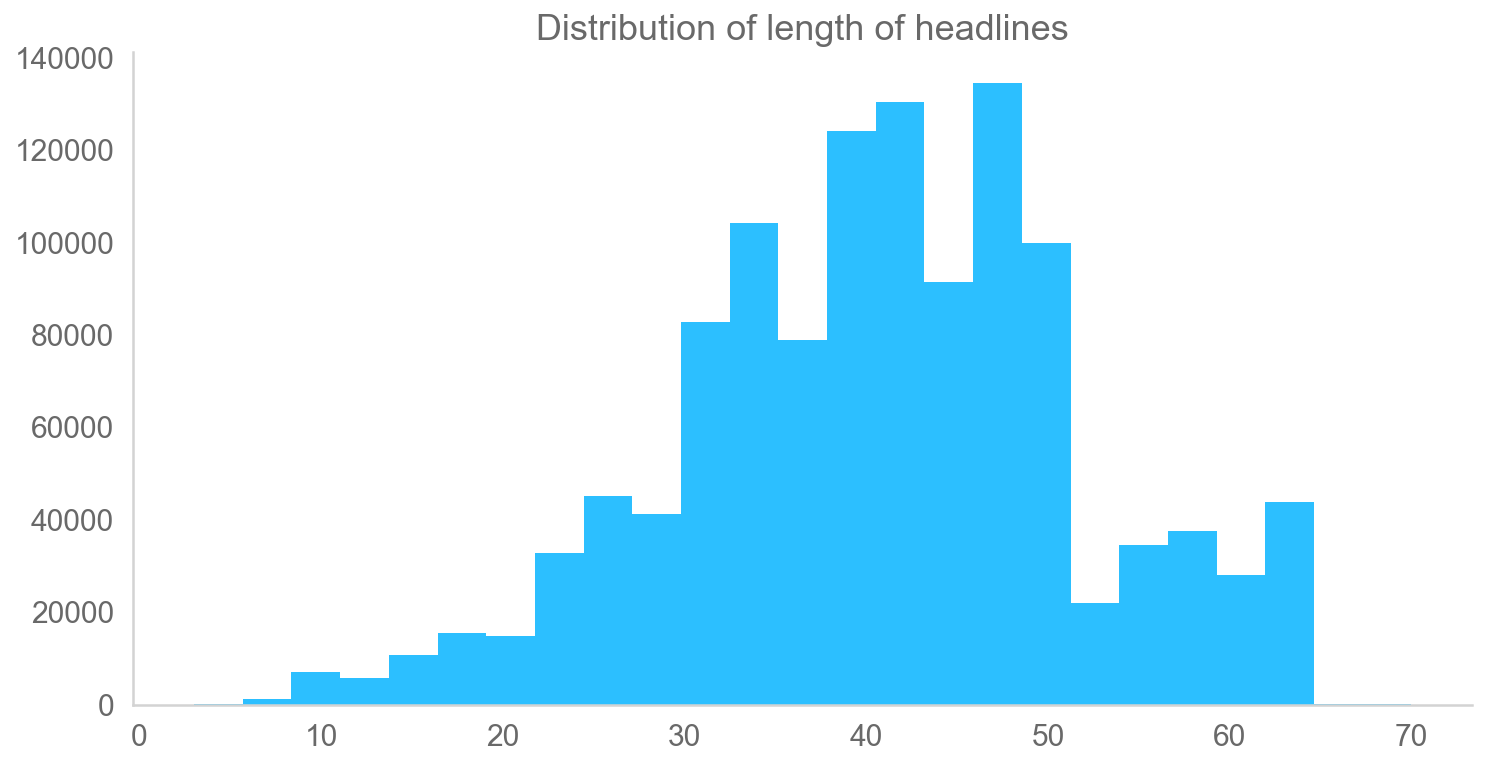

In [6]:
df["headline_text"].str.len().hist(figsize=(12, 6), bins=25, color="#2CBFFF", ec="none", grid=None)
plt.title("Distribution of length of headlines");

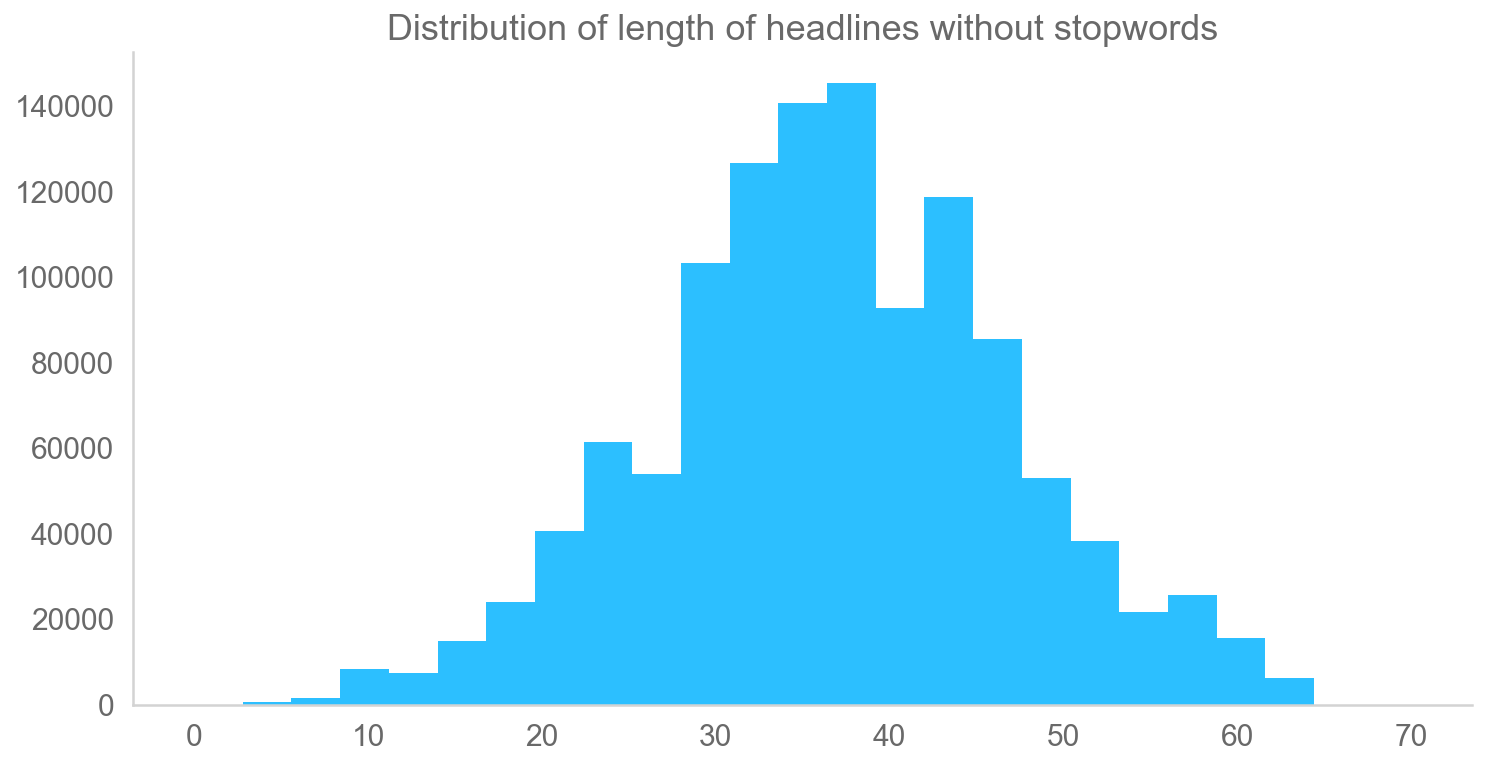

In [7]:
df["headline_without_stops"].str.len().hist(figsize=(12, 6), bins=25, color="#2CBFFF", ec="none", grid=None)
plt.title("Distribution of length of headlines without stopwords");

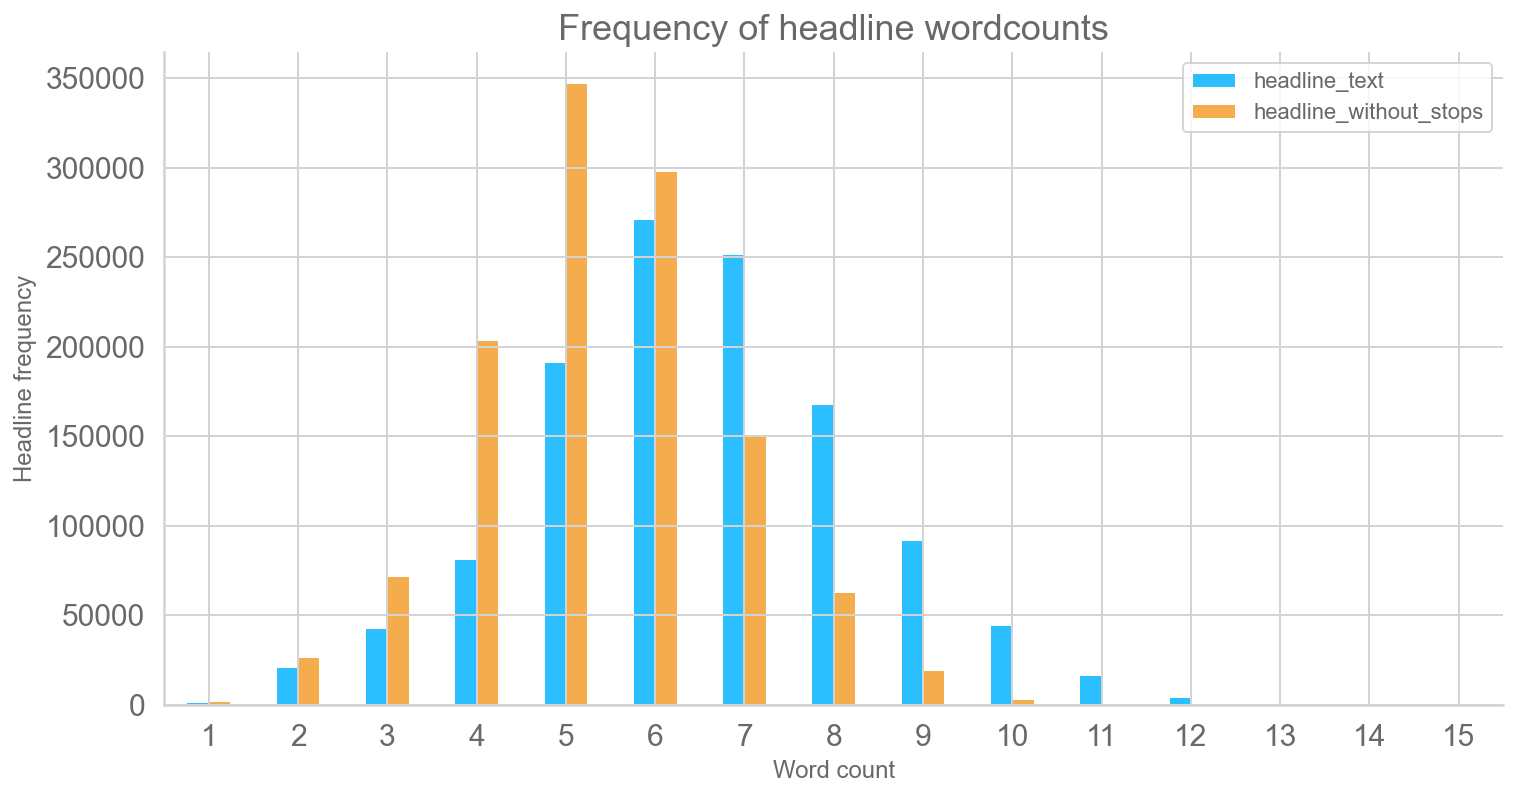

In [8]:
df["headline_text"].str.split().apply(lambda s: len(s)).value_counts().sort_index().to_frame().join(
    df["headline_without_stops"].str.split().apply(lambda s: len(s)).value_counts().sort_index().to_frame()
).fillna(0).astype(int).plot.bar(figsize=(12, 6), color=["#2CBFFF", "#F5AC4C"])
plt.title("Frequency of headline wordcounts")
plt.xlabel("Word count")
plt.ylabel("Headline frequency")
plt.xticks(rotation="horizontal");

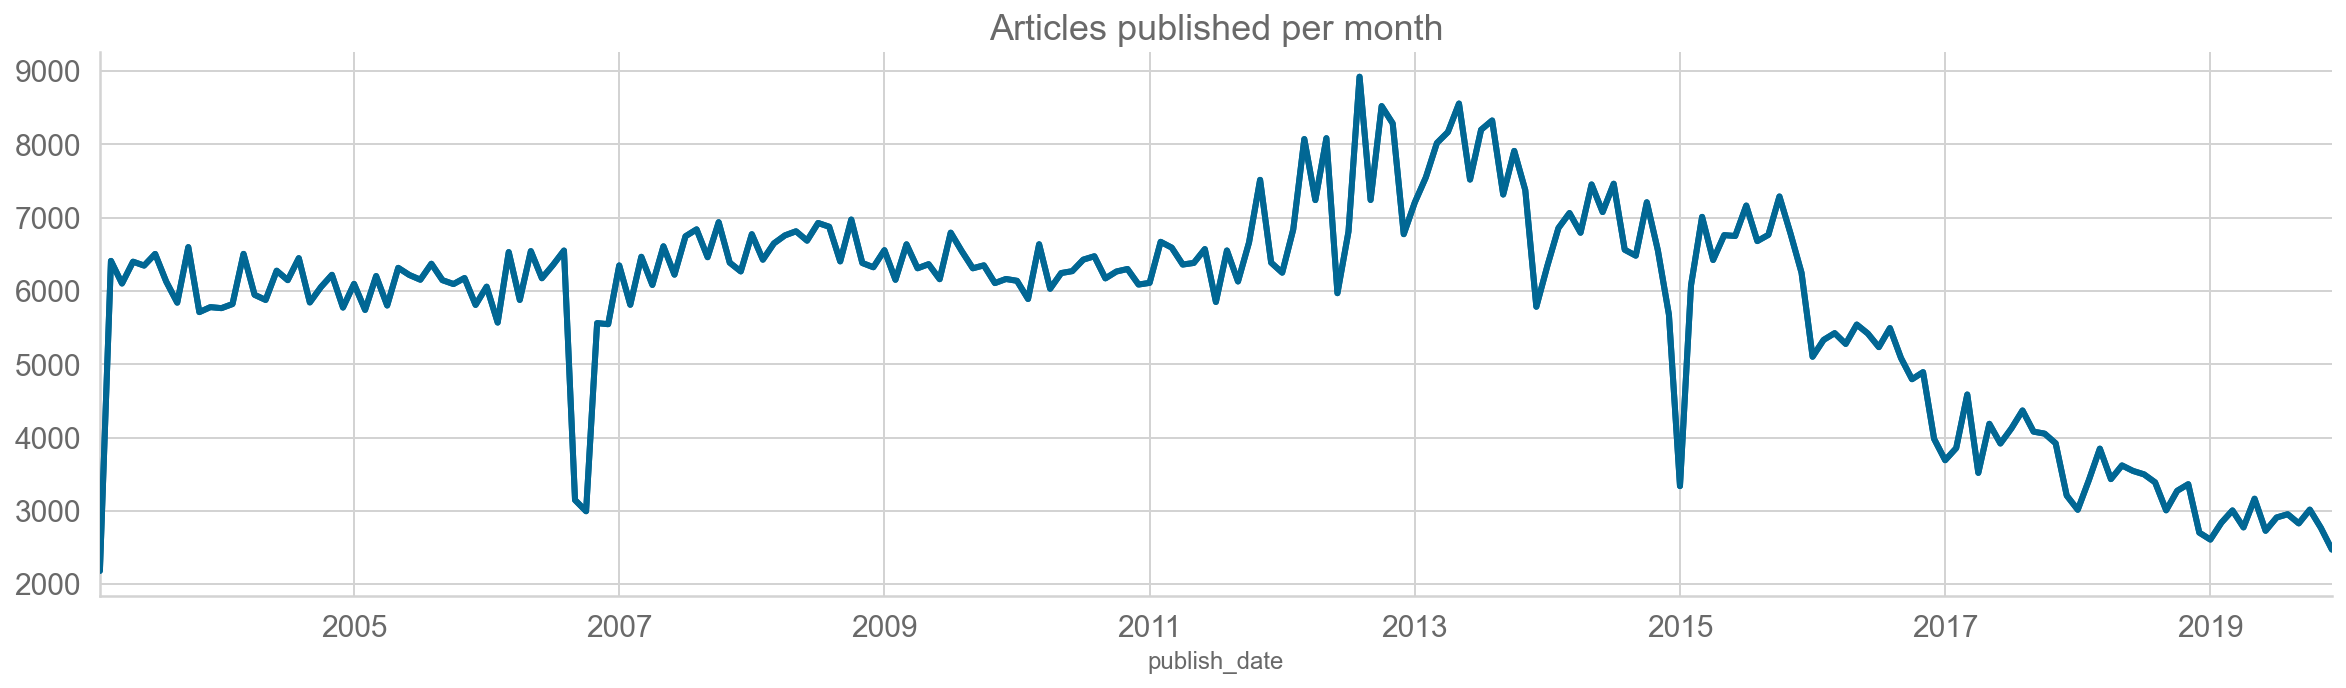

In [9]:
df.set_index("publish_date").resample("M").count().plot(figsize=(20, 5), color="#016794", lw=3, zorder=10, legend=None)
plt.title("Articles published per month");

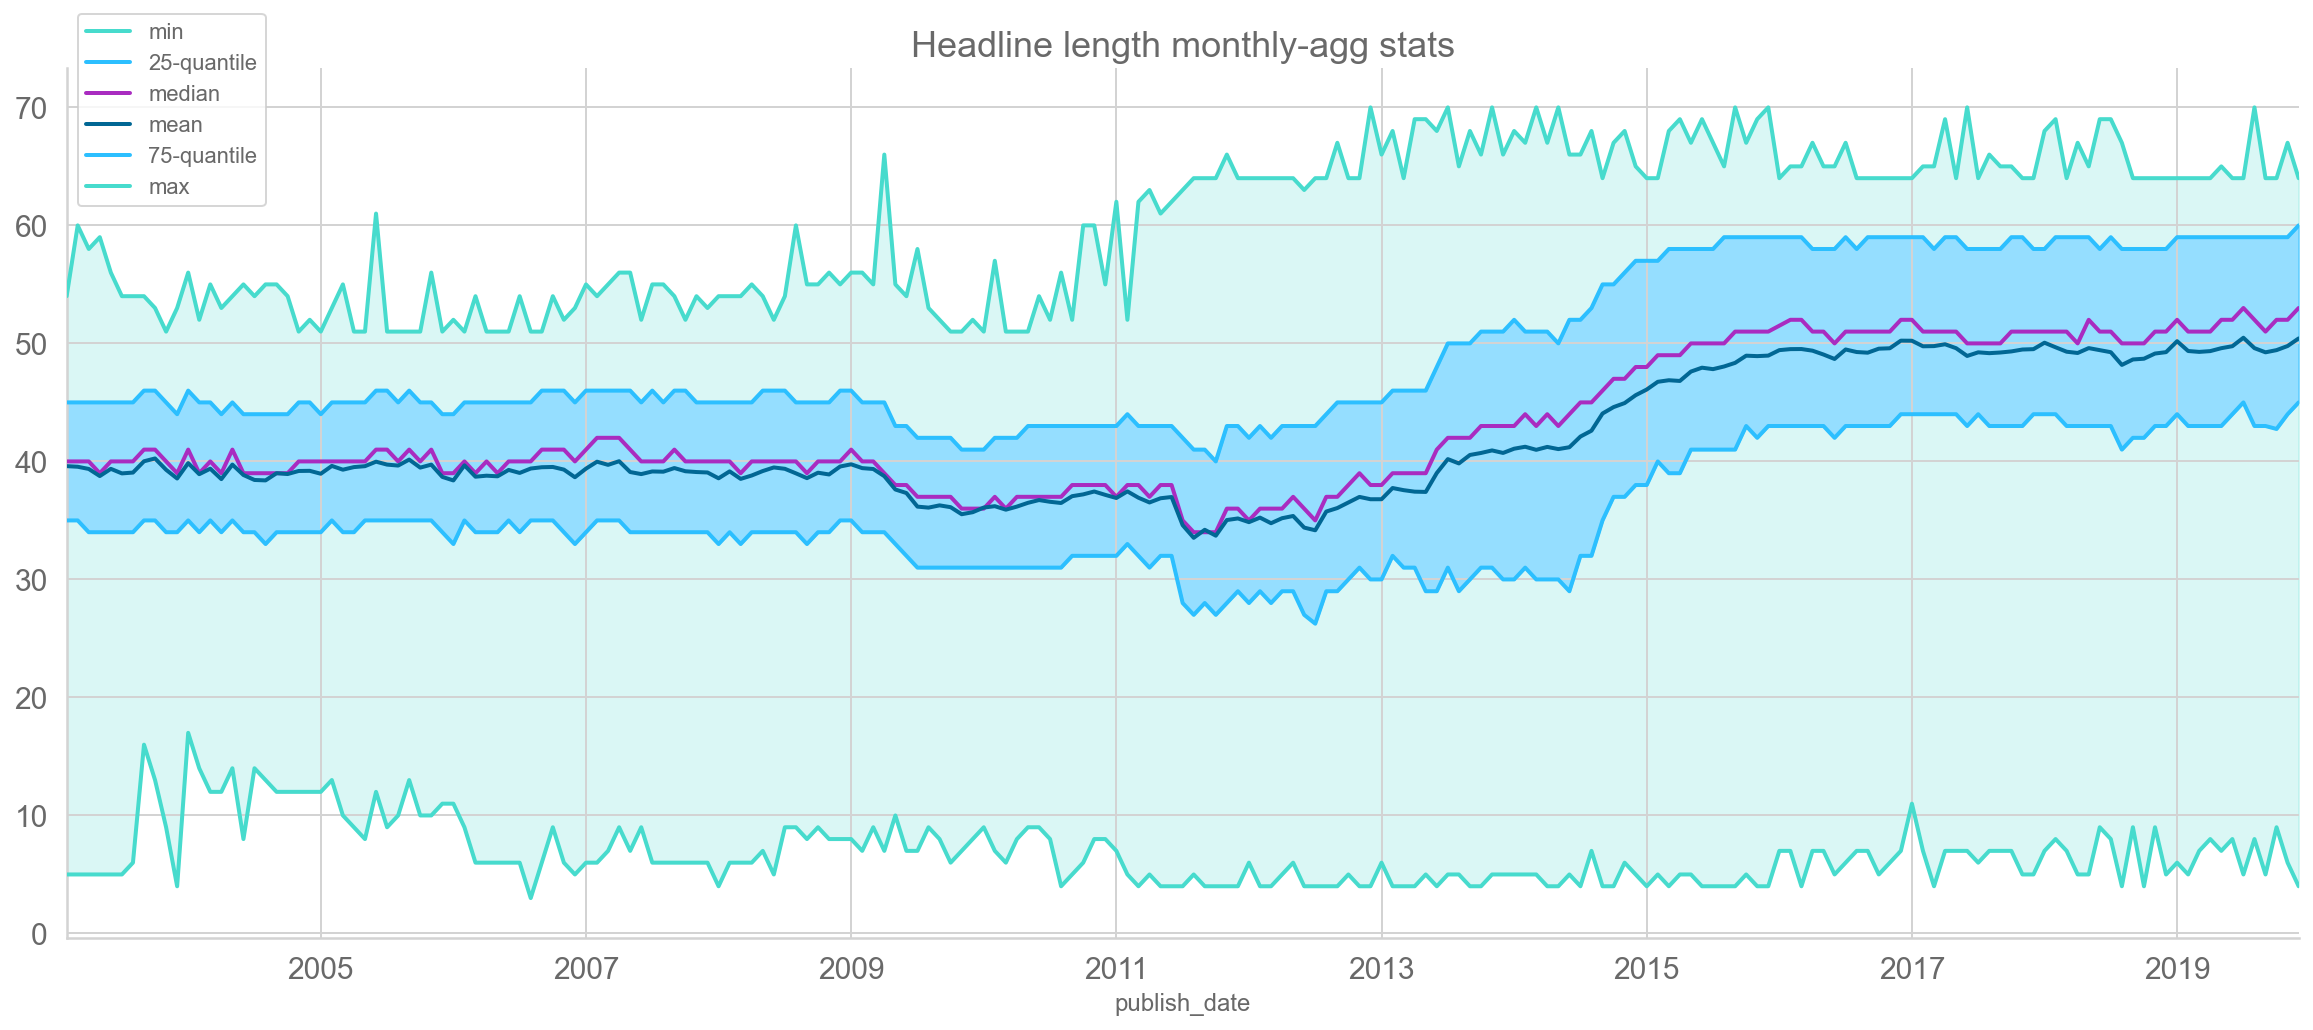

In [10]:
headline_len_stats = (
    df.assign(headline_length=df["headline_text"].str.len())
    .set_index("publish_date")
    .resample("M")
    .agg({"headline_length": ["min",
                              lambda s: np.percentile(s, 25),
                              "median",
                              "mean",
                              lambda s: np.percentile(s, 75),
                              "max"]}))["headline_length"]
headline_len_stats.rename(columns={"<lambda_0>": "25-quantile", "<lambda_1>": "75-quantile"}, inplace=True)

headline_len_stats.plot(figsize=(20, 8),
                        color=["#47DBCD", "#2CBFFF", "#A92CC0", "#016794", "#2CBFFF", "#47DBCD"],
                        lw=2,
                        zorder=10)
plt.fill_between(headline_len_stats.index,
                 headline_len_stats["25-quantile"],
                 headline_len_stats["75-quantile"],
                 color='#2CBFFF', alpha=.5)
plt.fill_between(headline_len_stats.index,
                 headline_len_stats["max"],
                 headline_len_stats["75-quantile"],
                 color="#47DBCD", alpha=.2)
plt.fill_between(headline_len_stats.index,
                 headline_len_stats["min"],
                 headline_len_stats["25-quantile"],
                 color="#47DBCD", alpha=.2)
plt.title("Headline length monthly-agg stats")
plt.legend(bbox_to_anchor=(0, 1.075), loc="upper left");

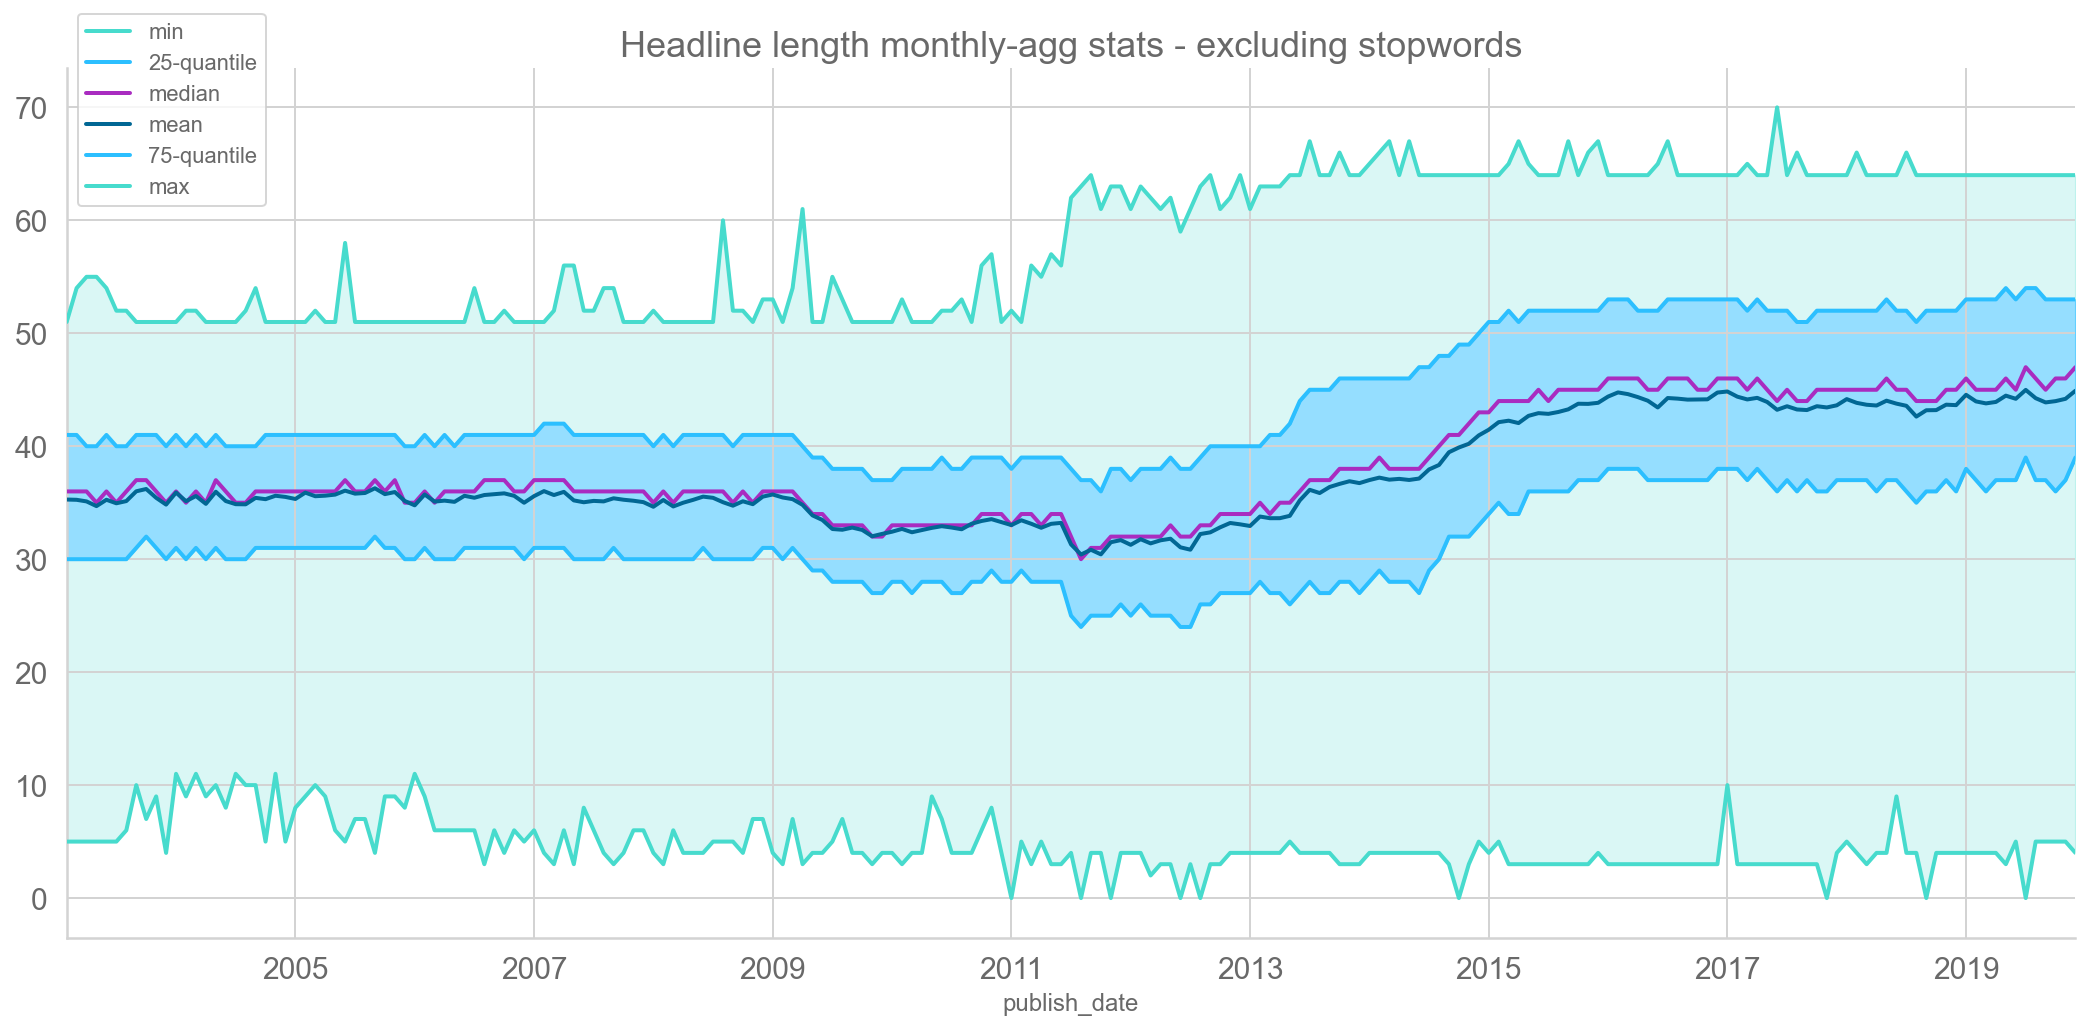

In [11]:
headline_len_stats = (
    df.assign(headline_length=df["headline_without_stops"].str.len())
    .set_index("publish_date")
    .resample("M")
    .agg({"headline_length": ["min",
                              lambda s: np.percentile(s, 25),
                              "median",
                              "mean",
                              lambda s: np.percentile(s, 75),
                              "max"]}))["headline_length"]
headline_len_stats.rename(columns={"<lambda_0>": "25-quantile", "<lambda_1>": "75-quantile"}, inplace=True)

headline_len_stats.plot(figsize=(18, 8),
                        color=["#47DBCD", "#2CBFFF", "#A92CC0", "#016794", "#2CBFFF", "#47DBCD"],
                        lw=2,
                        zorder=10)
plt.fill_between(headline_len_stats.index,
                 headline_len_stats["25-quantile"],
                 headline_len_stats["75-quantile"],
                 color='#2CBFFF', alpha=.5)
plt.fill_between(headline_len_stats.index,
                 headline_len_stats["max"],
                 headline_len_stats["75-quantile"],
                 color="#47DBCD", alpha=.2)
plt.fill_between(headline_len_stats.index,
                 headline_len_stats["min"],
                 headline_len_stats["25-quantile"],
                 color="#47DBCD", alpha=.2)
plt.title("Headline length monthly-agg stats - excluding stopwords")
plt.legend(bbox_to_anchor=(0, 1.075), loc="upper left");

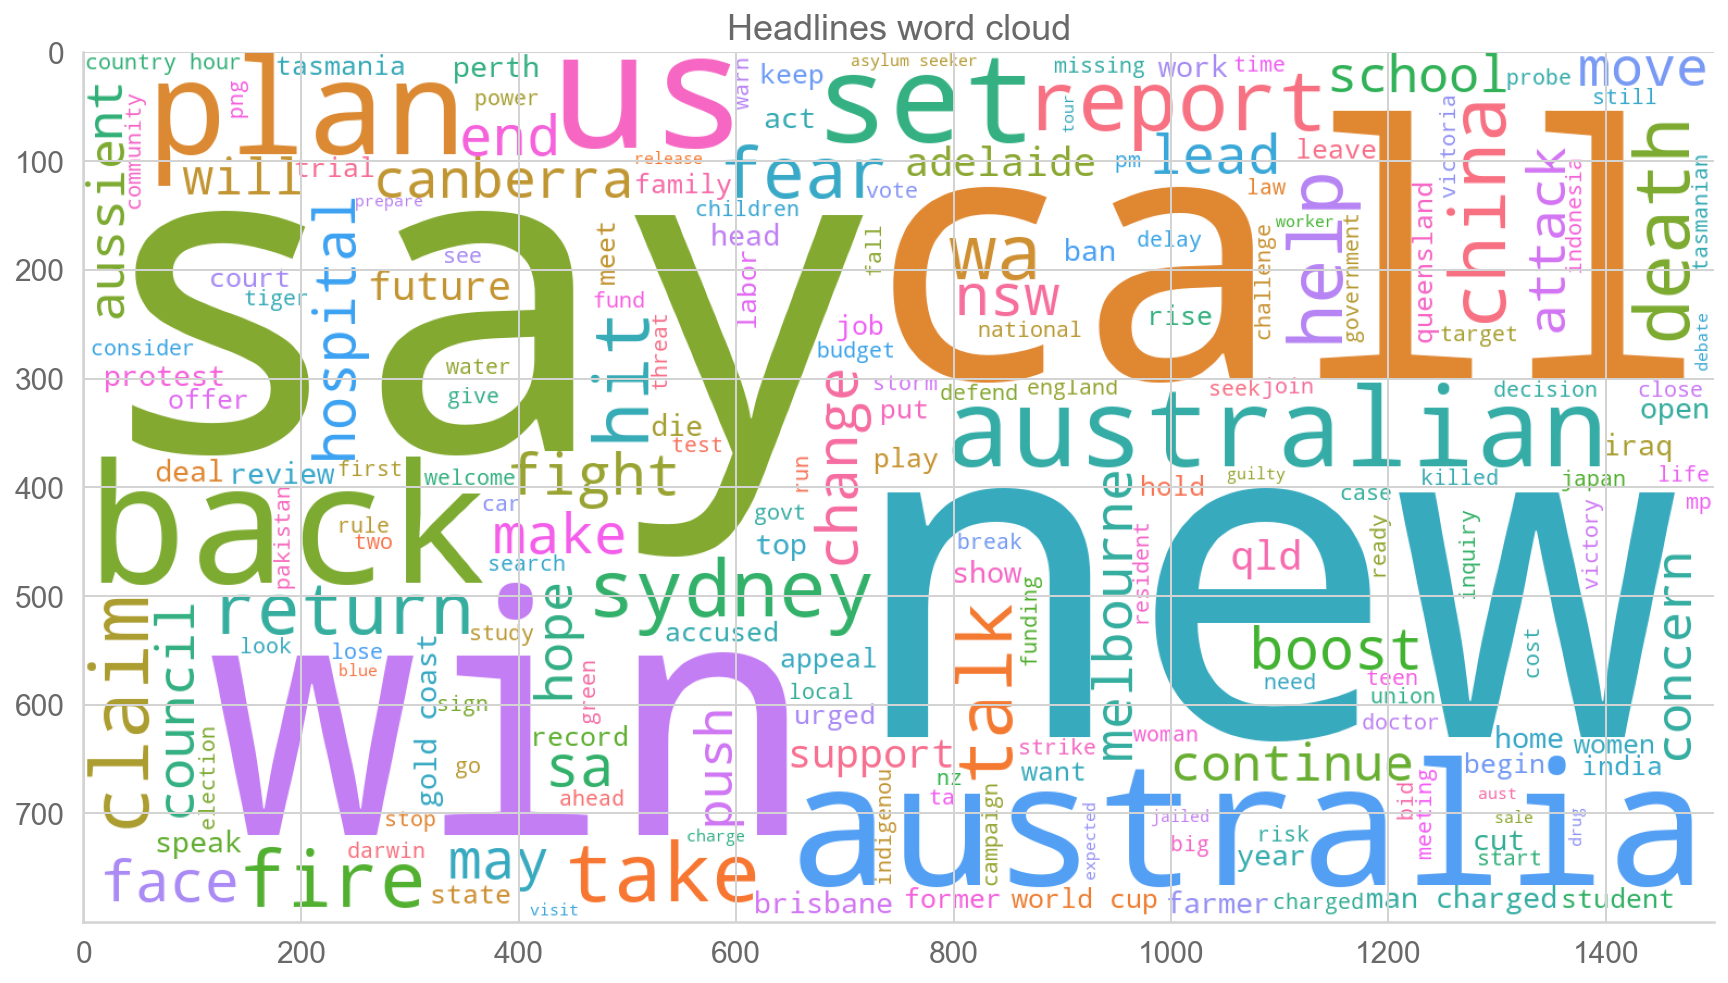

In [12]:
wcloud = wordcloud.WordCloud(background_color="white", width=1500, height=800,
                             colormap=sns.color_palette("husl", as_cmap=True)).generate(' '.join(df["headline_text"]))
plt.figure(figsize=(15, 8)) 
plt.imshow(wcloud) 
plt.title("Headlines word cloud");

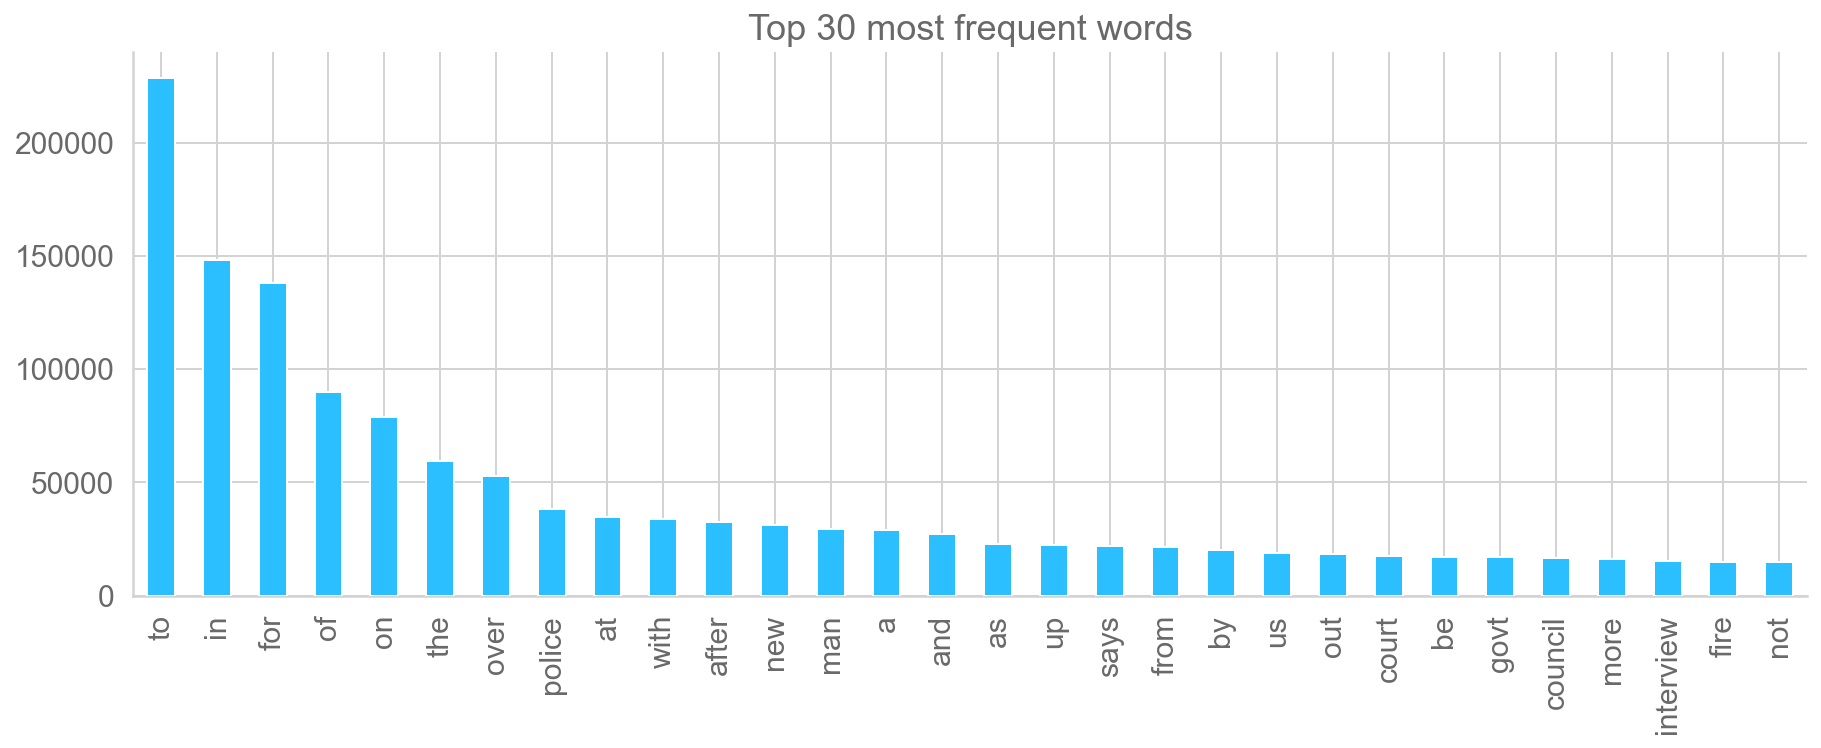

In [13]:
words = list(chain(*df['headline_text'].str.split()))
pd.Series(words).value_counts().head(30).plot.bar(figsize=(15, 5), color="#2CBFFF", zorder=10)
plt.title("Top 30 most frequent words");

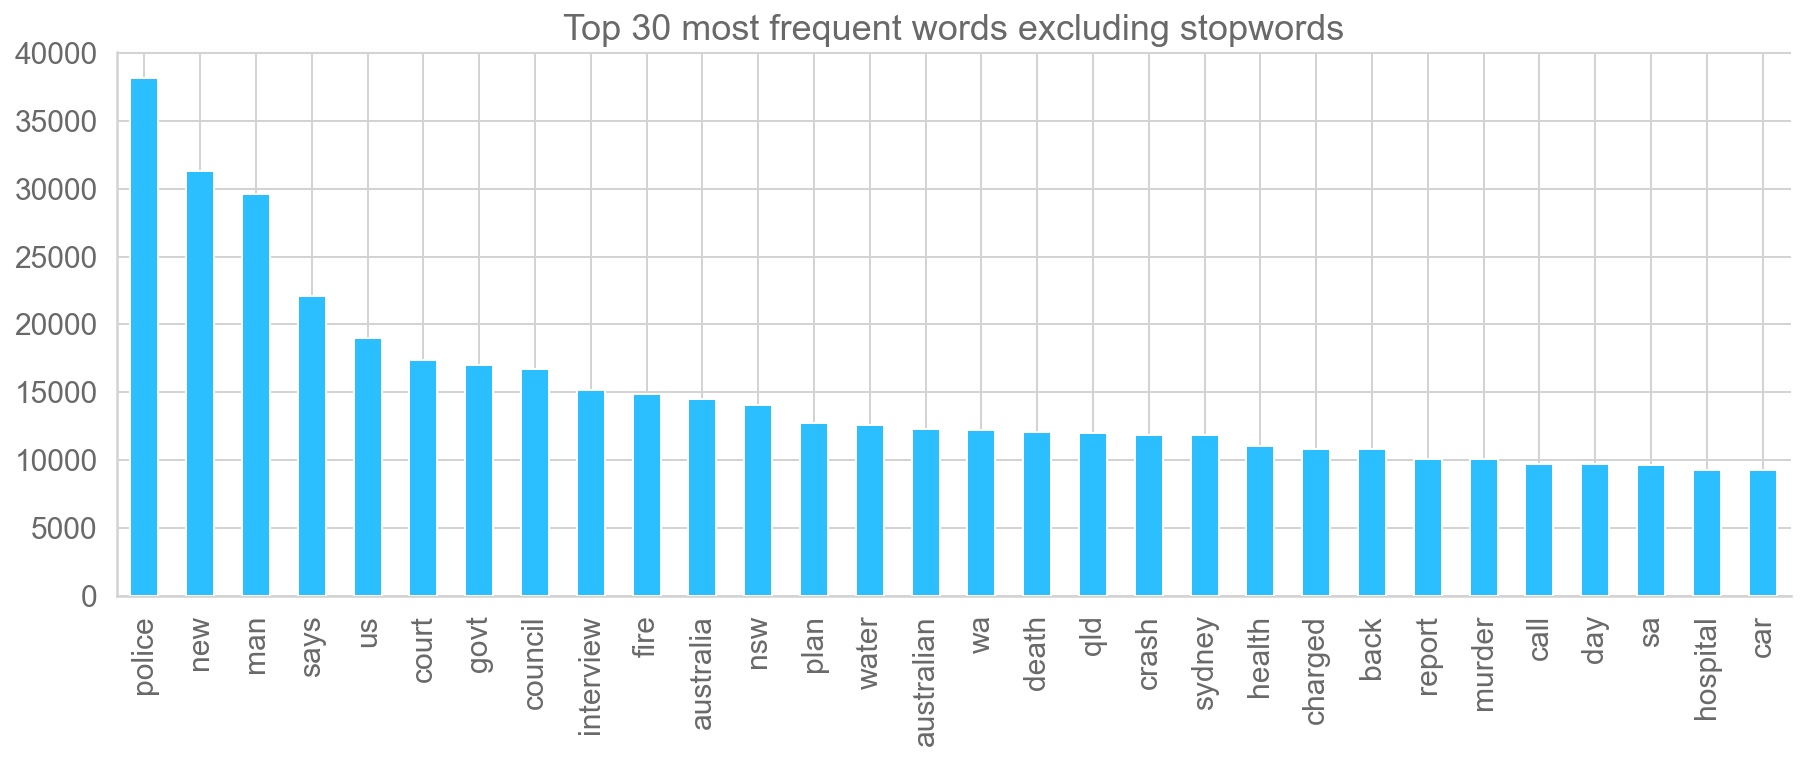

In [14]:
words_without_eng_stops = list(chain(*df["headline_without_stops"].str.split()))
pd.Series(words_without_eng_stops).value_counts().head(30).plot.bar(figsize=(15, 5), color="#2CBFFF", zorder=10)
plt.title("Top 30 most frequent words excluding stopwords");

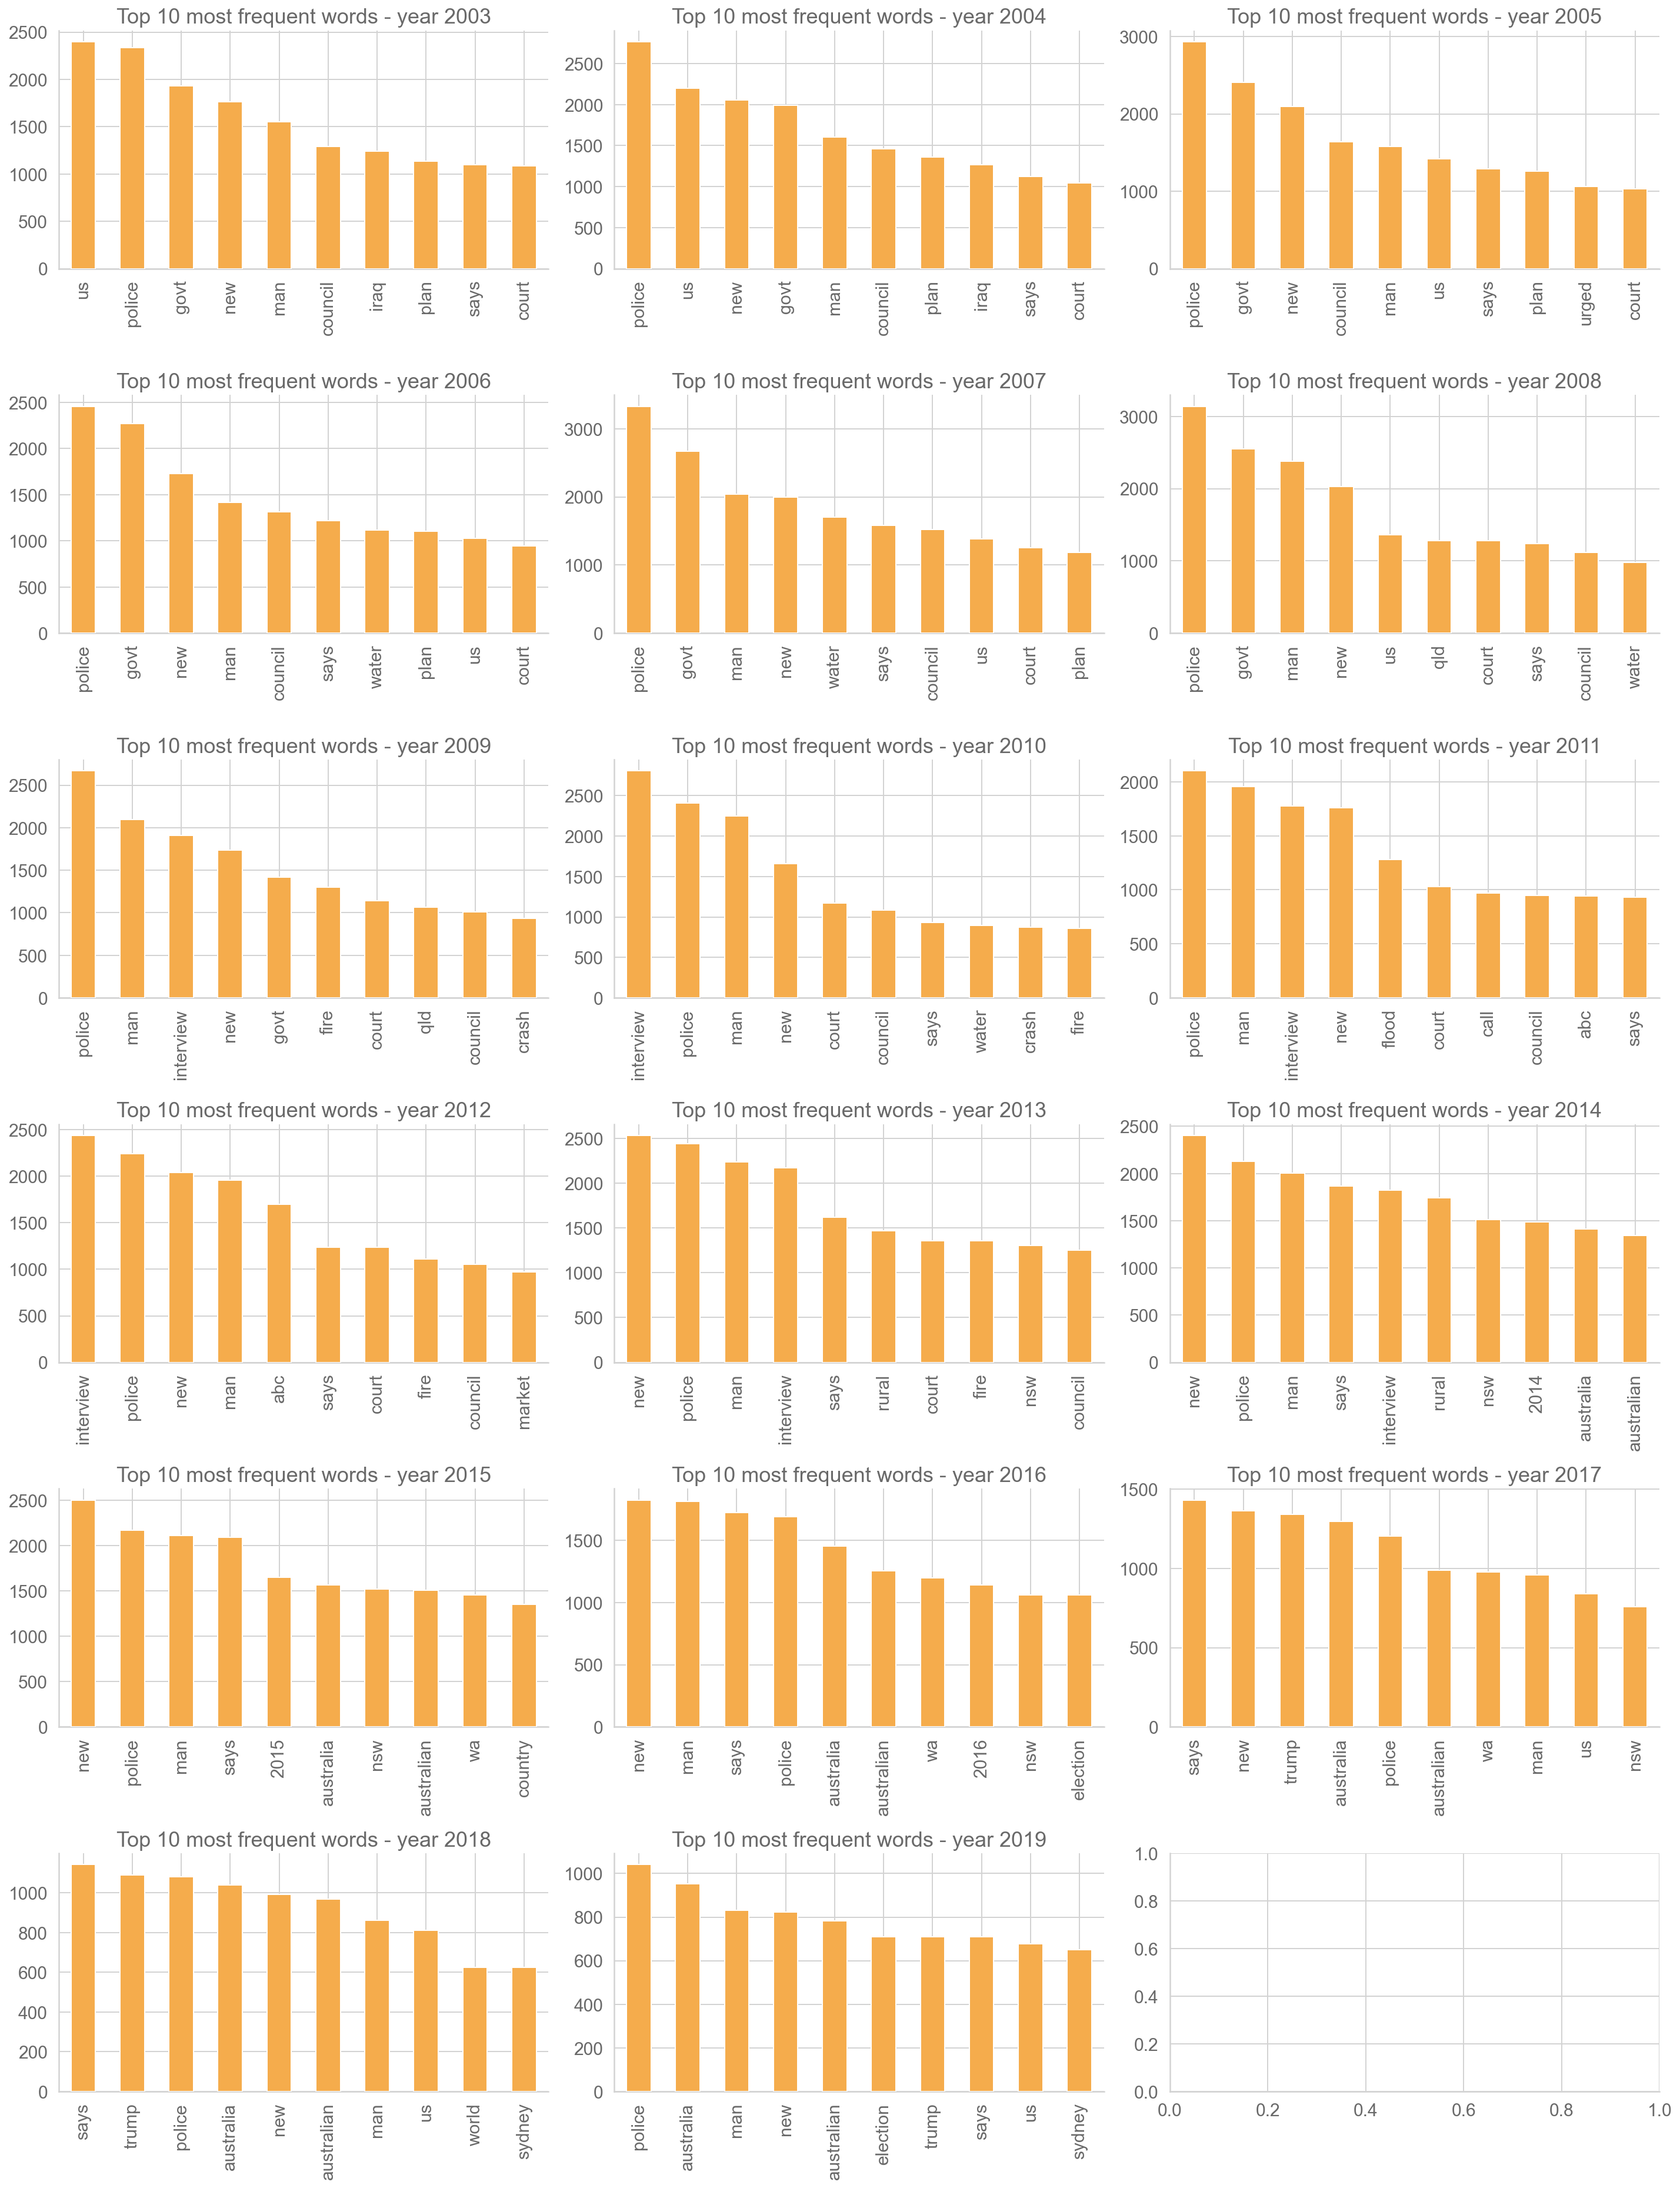

In [15]:
words_by_year = df.groupby(df["publish_date"].dt.year).agg({"headline_without_stops": lambda s: list(chain(*s.str.split()))})
fig, axes = plt.subplots(6, 3, figsize=(20, 26))
for year, ax in zip(words_by_year.index, list(chain(*axes))):
    words = words_by_year.loc[year]["headline_without_stops"]
    pd.Series(words).value_counts().head(10).plot.bar(ax=ax, color="#F5AC4C", zorder=10)
    ax.set_title(f"Top 10 most frequent words - year {year}")
fig.tight_layout()

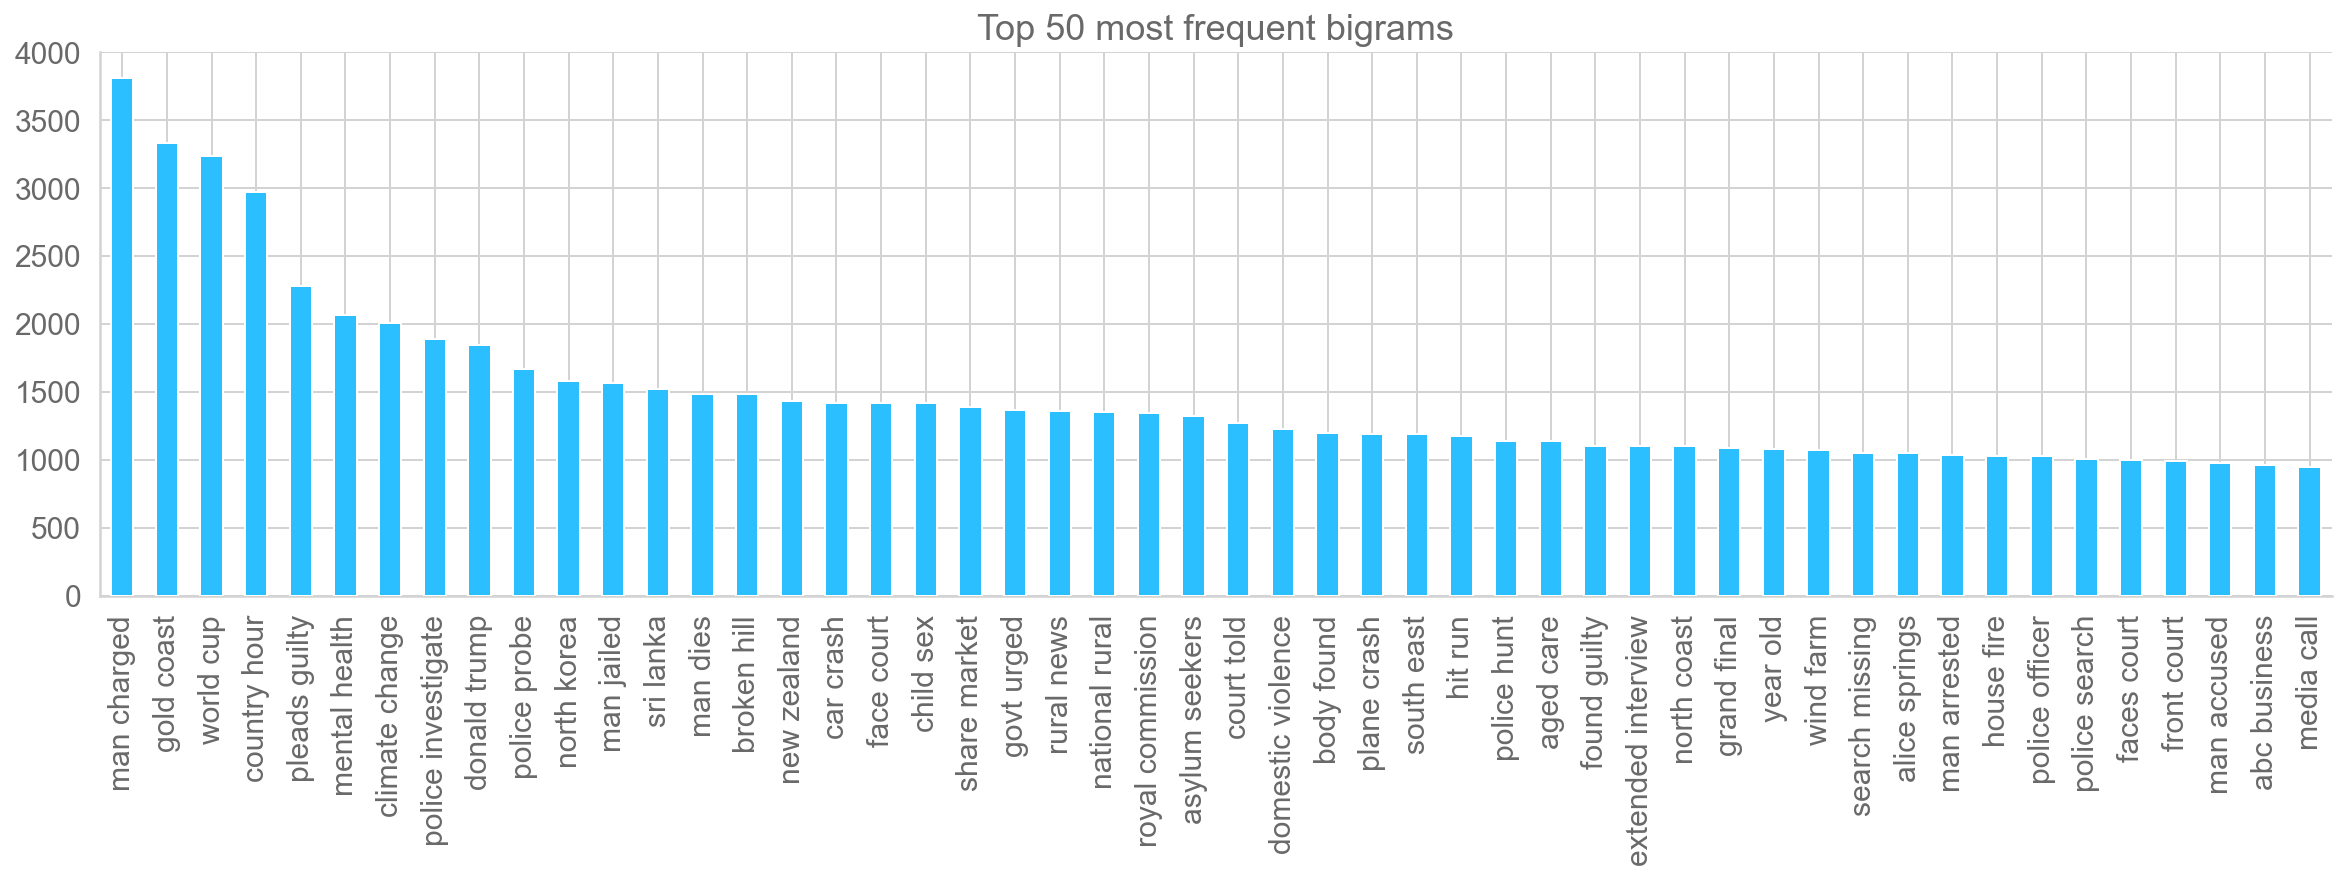

In [16]:
bigrams = df["headline_without_stops"].str.split().apply(lambda s: list(nltk.ngrams(s, 2)))
bigrams = pd.Series(chain(*bigrams))
bigrams.apply(lambda x: ' '.join(list(x))).value_counts().head(50).plot.bar(figsize=(20, 5), color="#2CBFFF", zorder=10)
plt.title("Top 50 most frequent bigrams");

In [17]:
def n_gram_agg_func(series, n):
    s = series.str.split().apply(lambda s: list(nltk.ngrams(s, n)))
    return list(chain(*s))

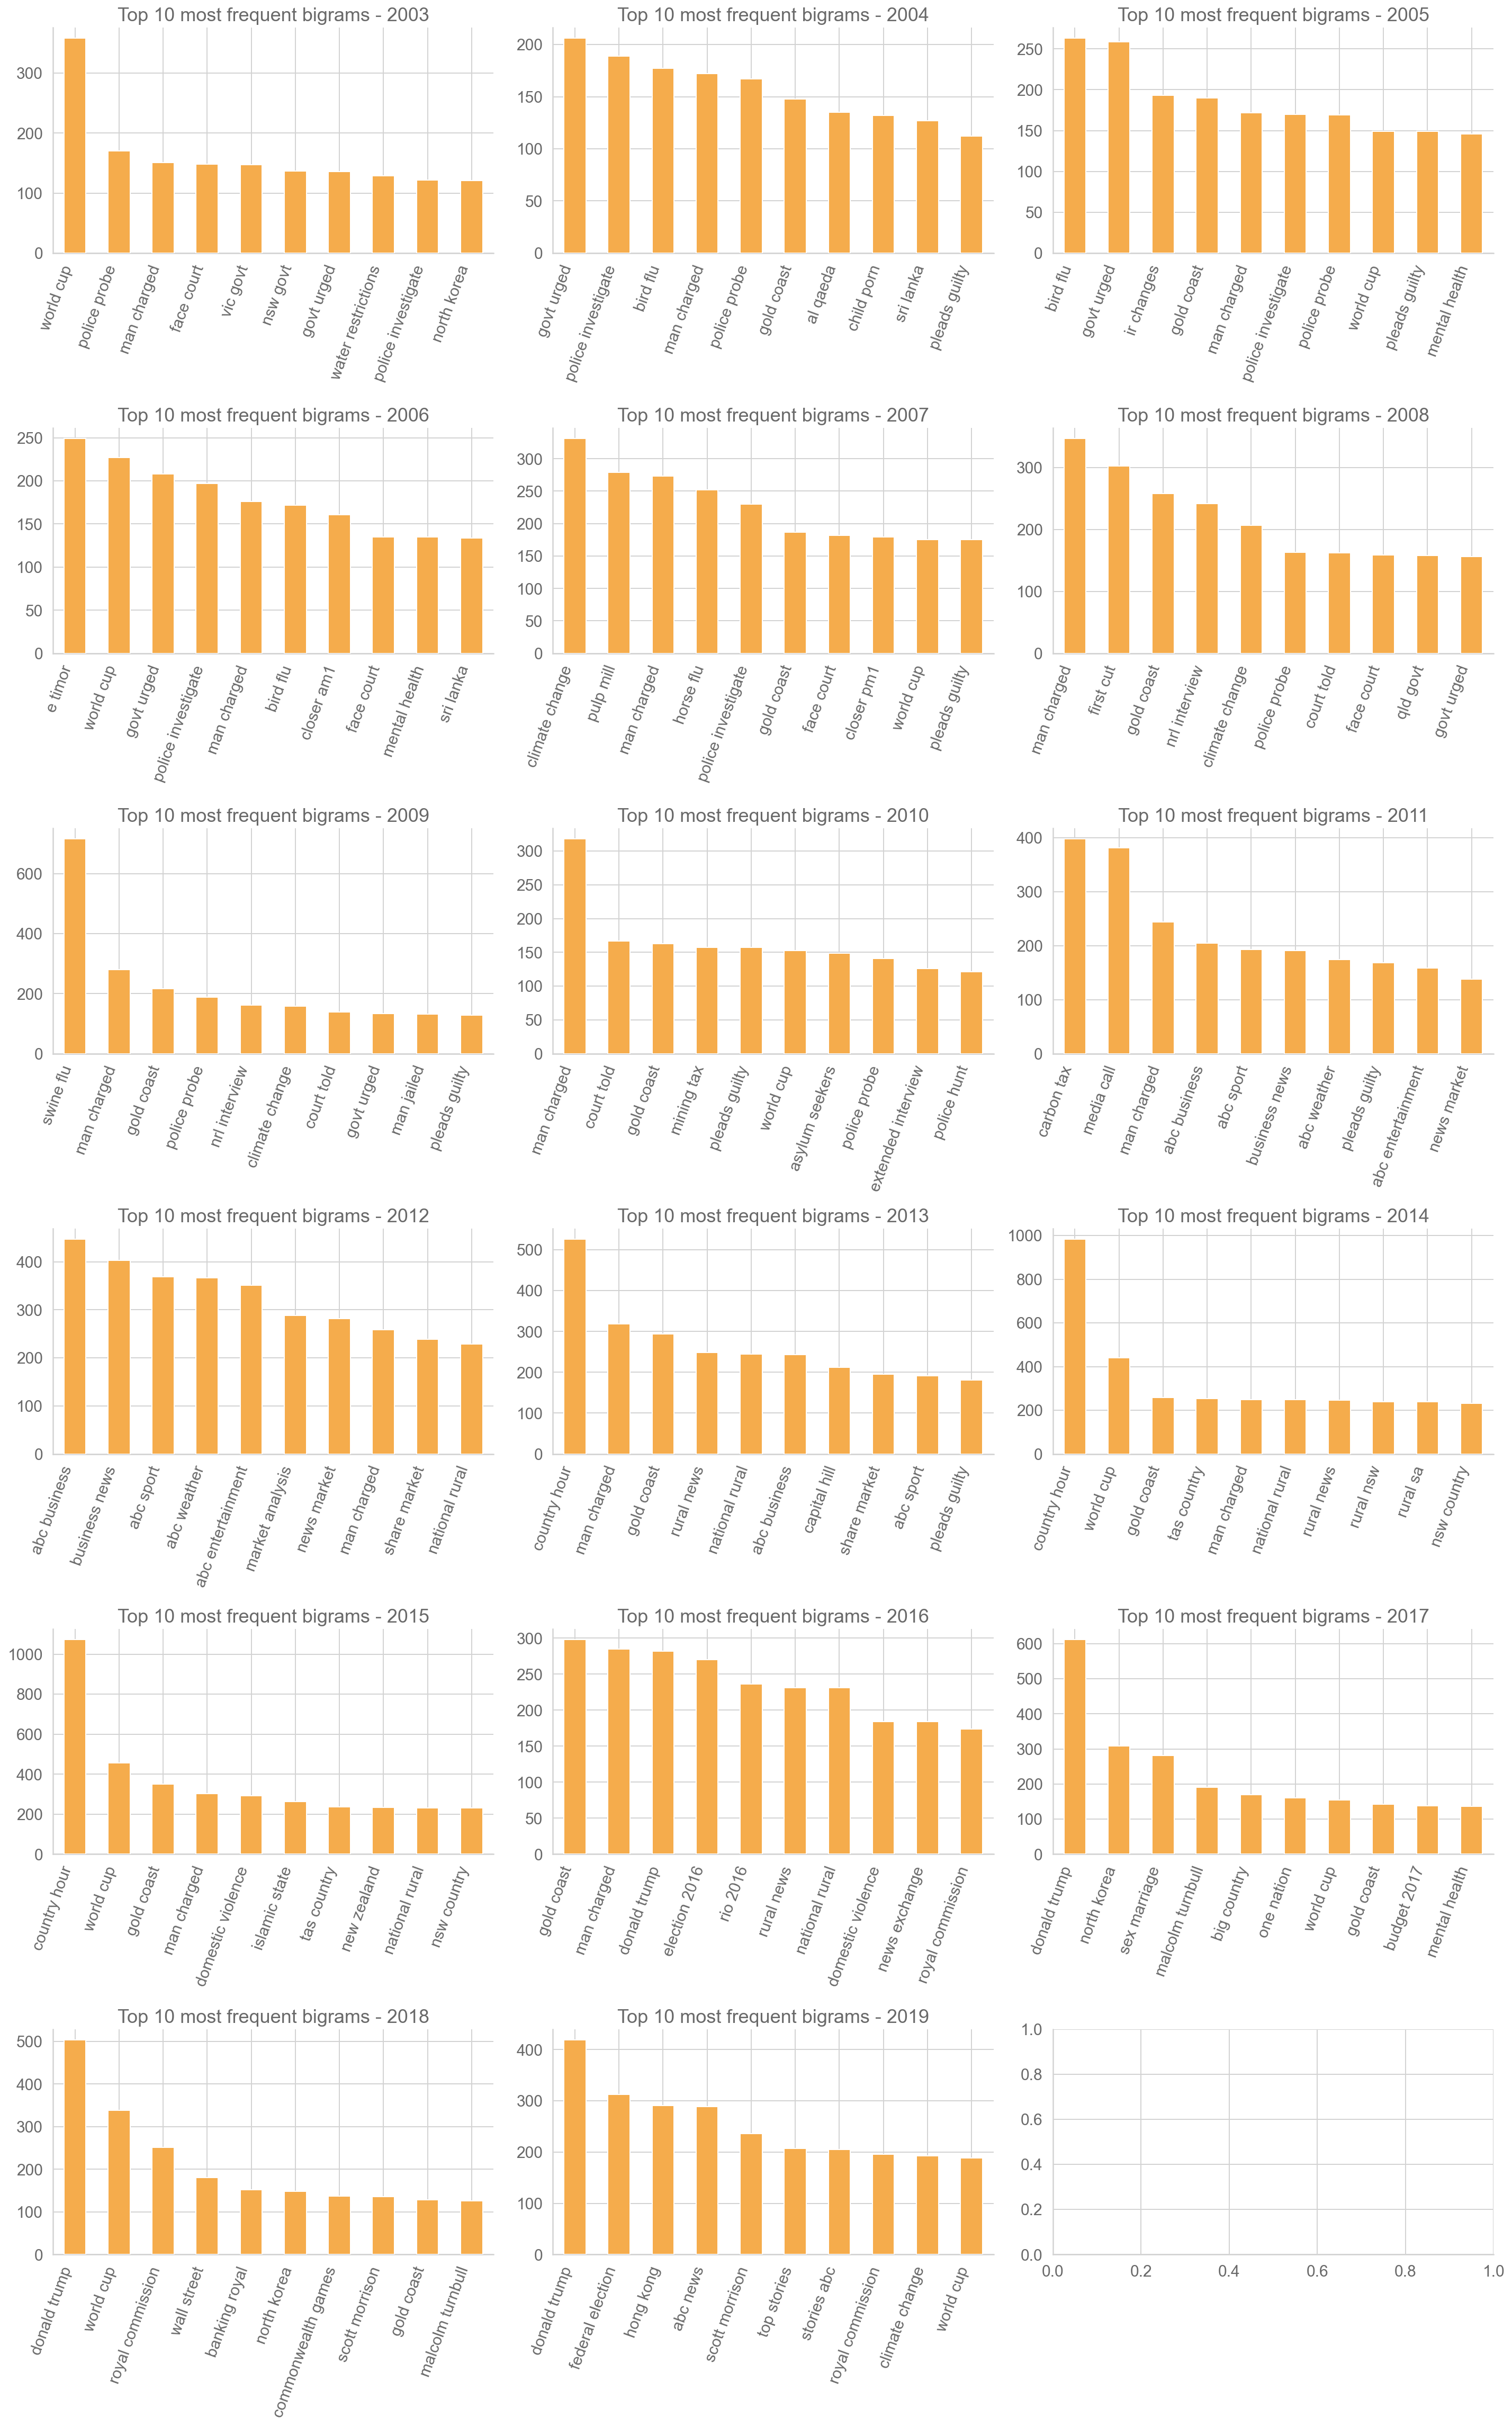

In [18]:
bigrams_by_year = (df.groupby(df["publish_date"].dt.year)
                   .agg({"headline_without_stops": lambda s: n_gram_agg_func(s, 2)}))
fig, axes = plt.subplots(6, 3, figsize=(20, 32))
for year, ax in zip(bigrams_by_year.index, list(chain(*axes))):
    year_bigrams = bigrams_by_year.loc[year]["headline_without_stops"]
    year_bigrams = [' '.join(list(t)) for t in year_bigrams]
    pd.Series(year_bigrams).value_counts().head(10).plot.bar(ax=ax, color="#F5AC4C", zorder=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha="right")
    ax.set_title(f"Top 10 most frequent bigrams - {year}")
fig.tight_layout()

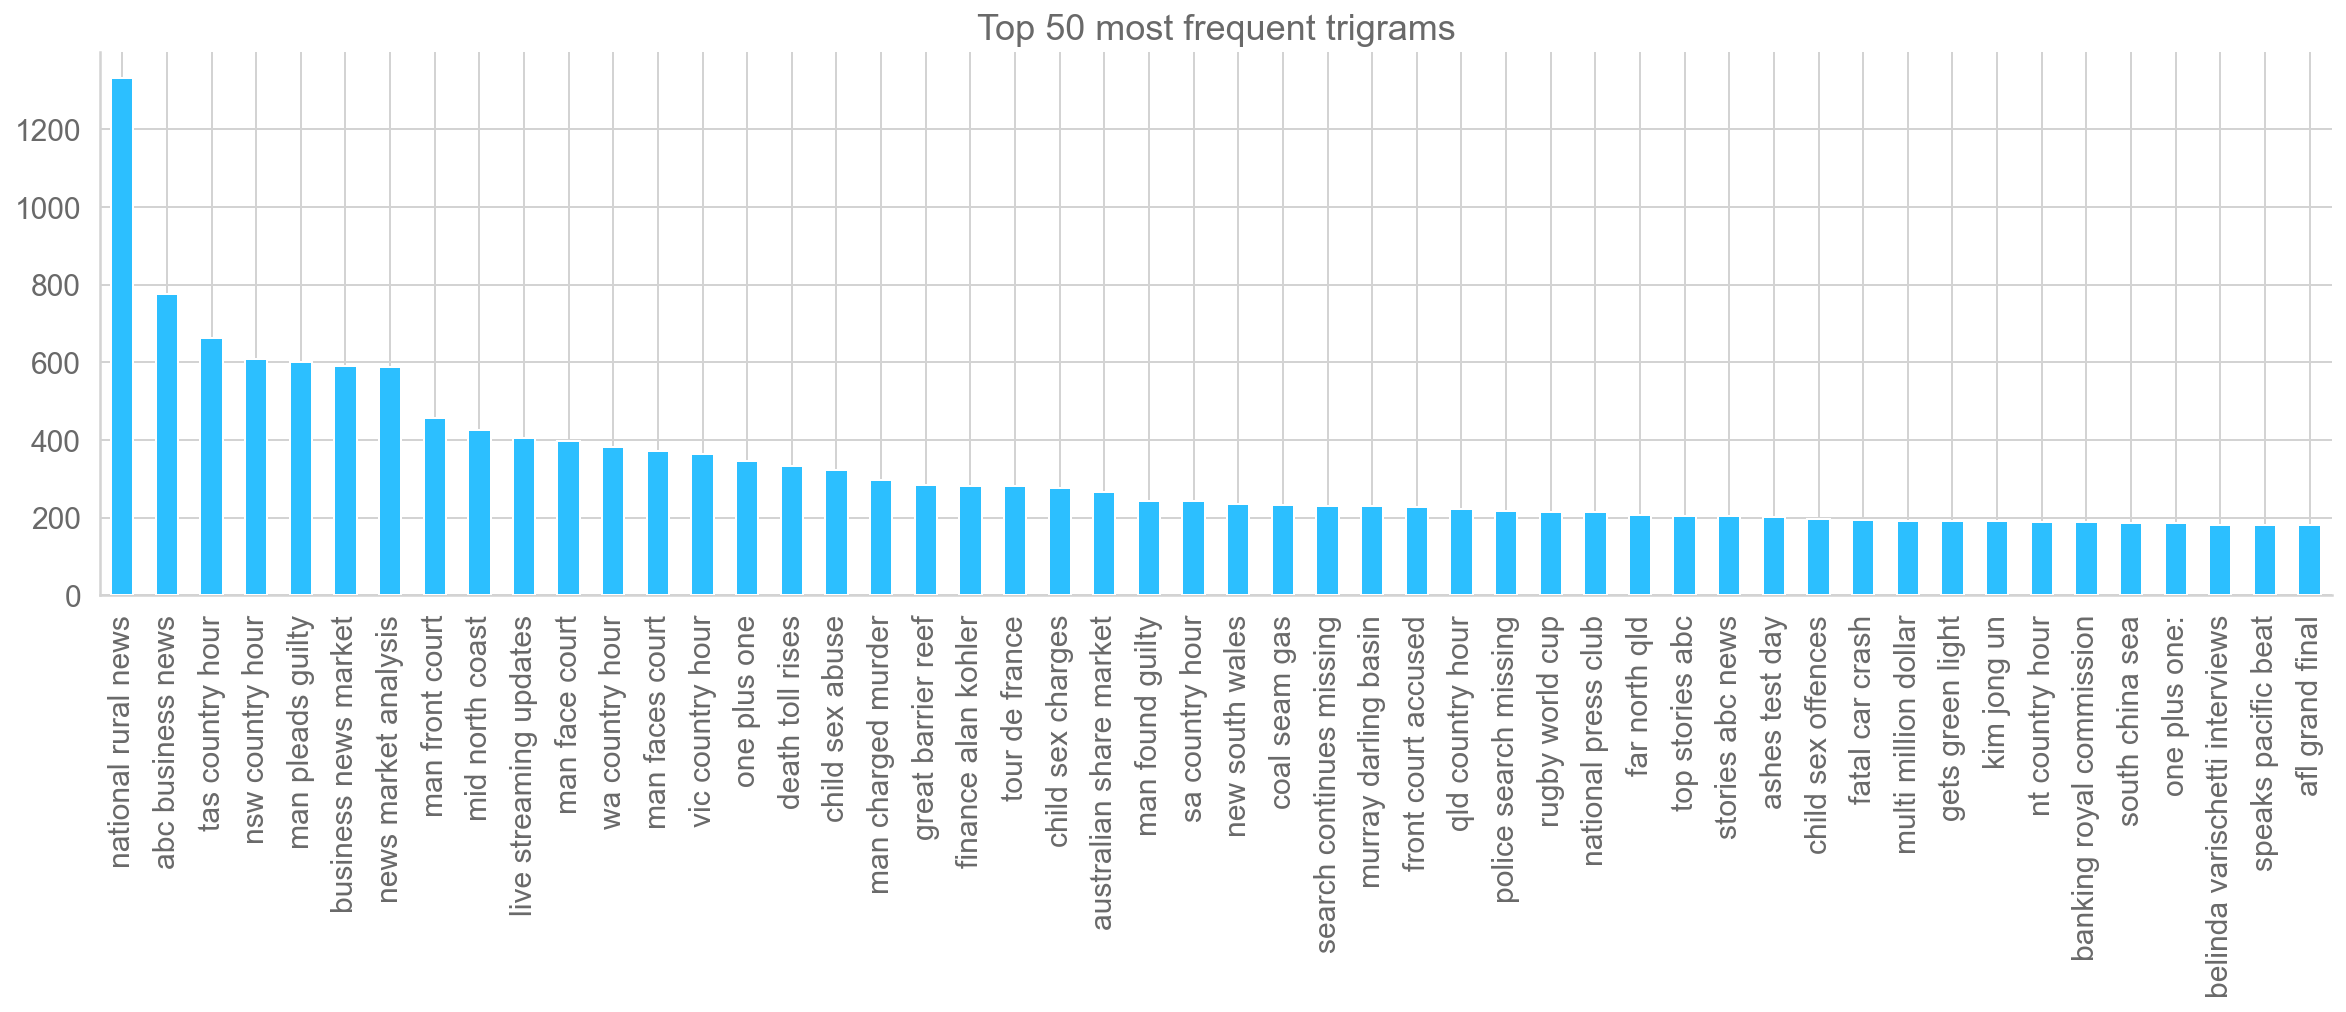

In [19]:
trigrams = df["headline_without_stops"].str.split().apply(lambda s: list(nltk.ngrams(s, 3)))
trigrams = pd.Series(chain(*trigrams))
(trigrams.apply(lambda x: ' '.join(list(x)))
 .value_counts().head(50)
 .plot.bar(figsize=(20, 5), color="#2CBFFF", zorder=10))
plt.title("Top 50 most frequent trigrams");

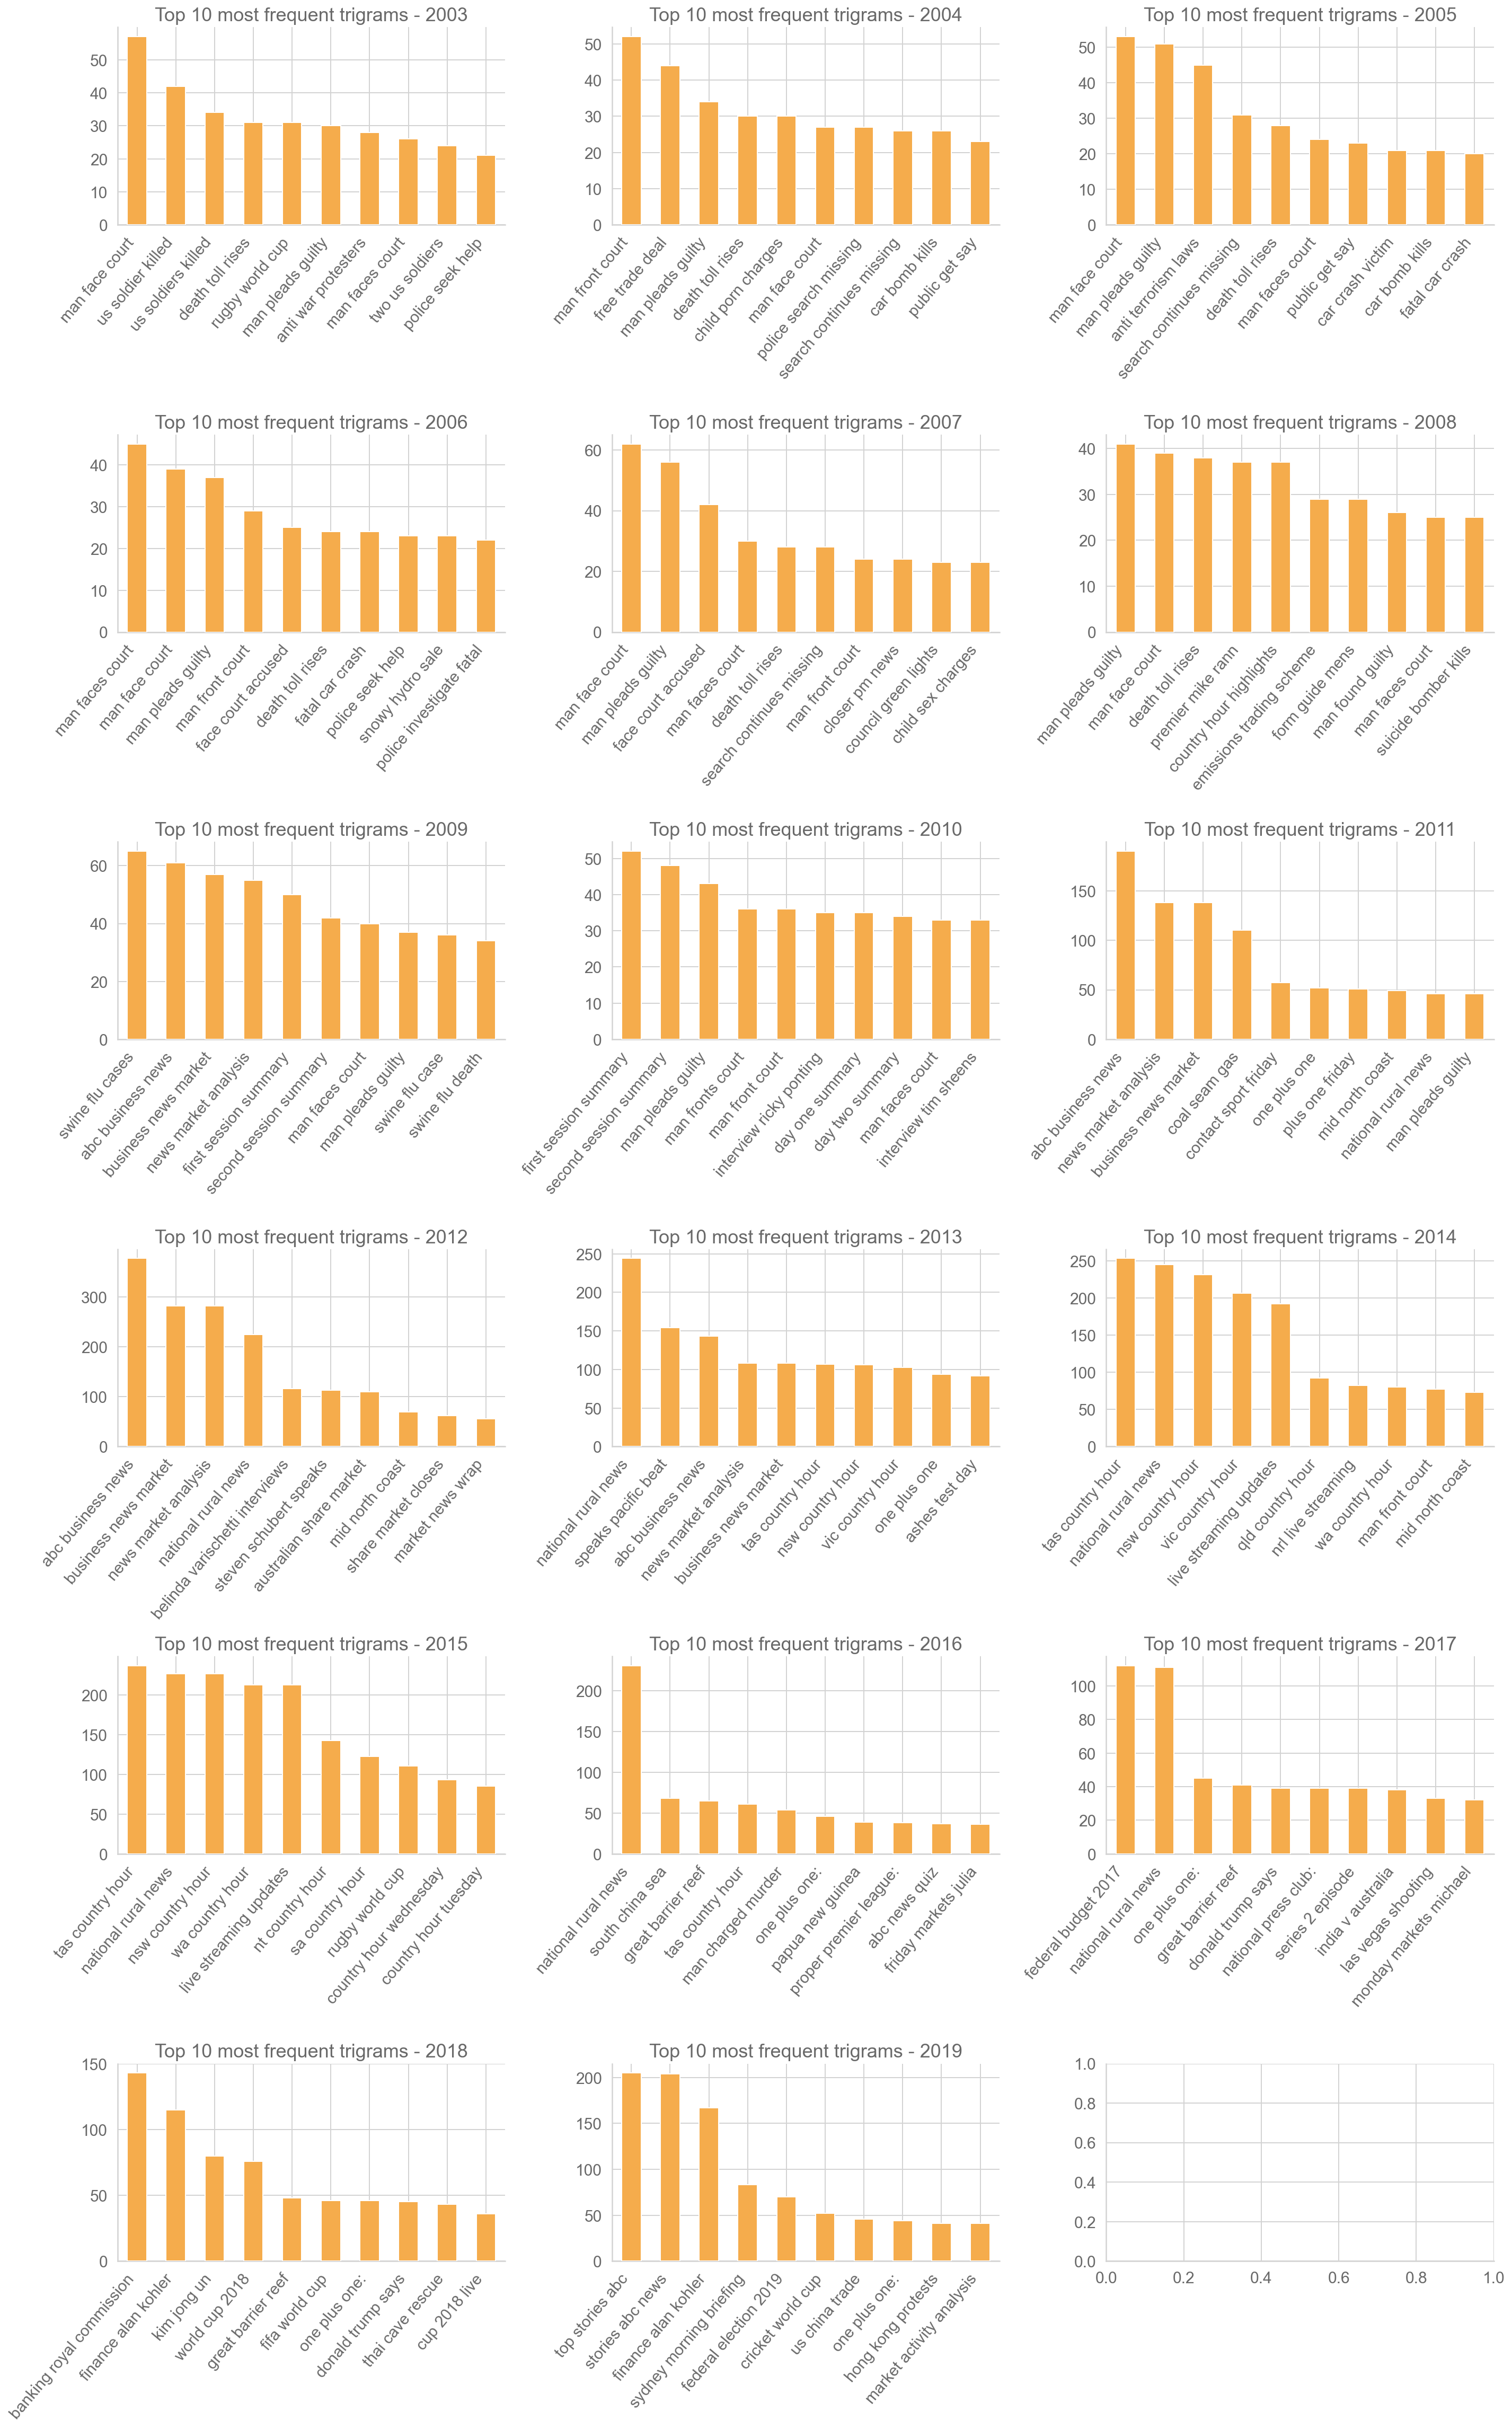

In [20]:
trigrams_by_year = (df.groupby(df["publish_date"].dt.year)
                    .agg({"headline_without_stops": lambda s: n_gram_agg_func(s, 3)}))
fig, axes = plt.subplots(6, 3, figsize=(20, 32))
for year, ax in zip(trigrams_by_year.index, list(chain(*axes))):
    year_trigrams = trigrams_by_year.loc[year]["headline_without_stops"]
    year_trigrams = [' '.join(list(t)) for t in year_trigrams]
    pd.Series(year_trigrams).value_counts().head(10).plot.bar(ax=ax, color="#F5AC4C", zorder=10)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
    ax.set_title(f"Top 10 most frequent trigrams - {year}")
fig.tight_layout()

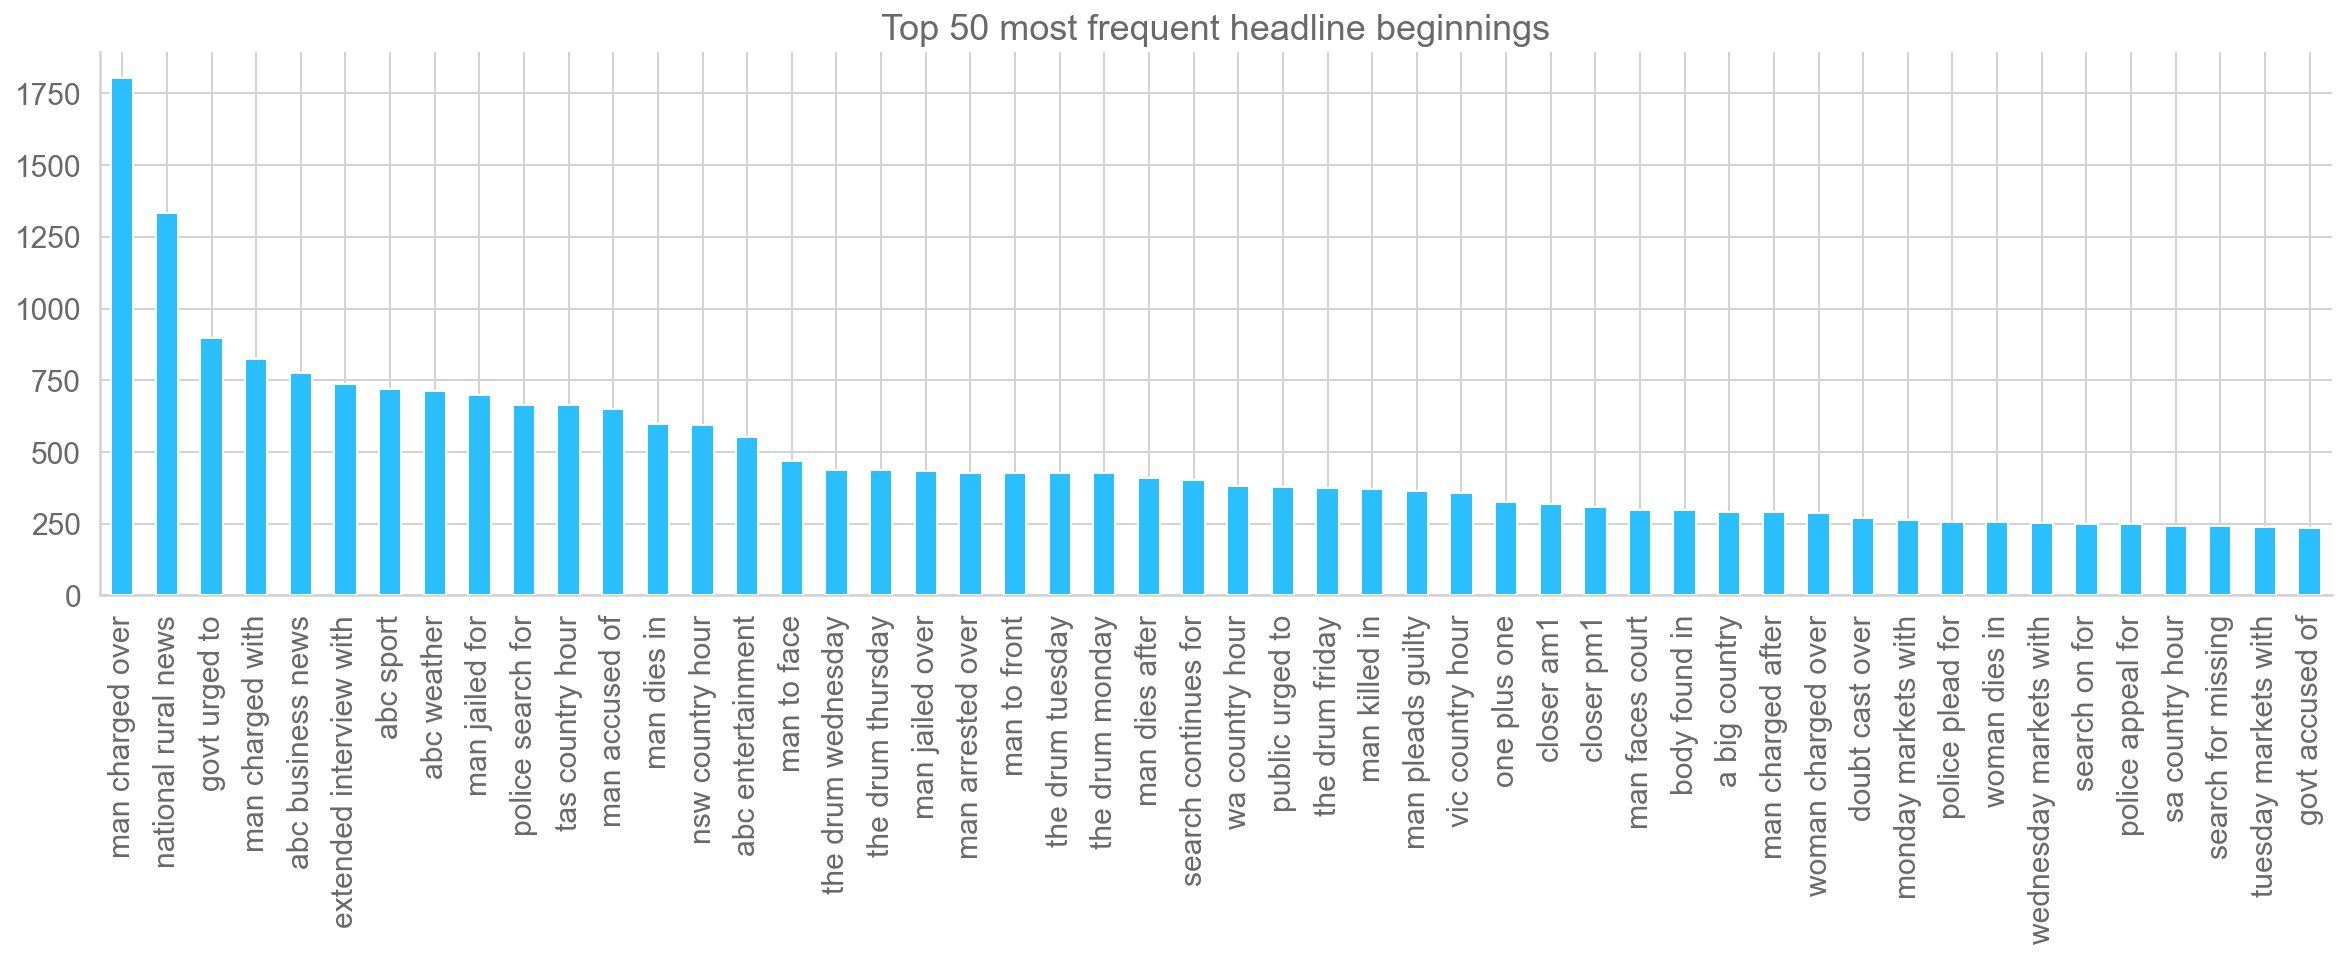

In [21]:
df["headline_text"].str.split().apply(lambda x: ' '.join(x[:3])).value_counts().head(50).plot.bar(figsize=(20, 5), color="#2CBFFF", zorder=10)
plt.title("Top 50 most frequent headline beginnings");

In [22]:
sia = SentimentIntensityAnalyzer()
eng_stops = stopwords.words("english")

df["polarity_scores"] = df["headline_without_stops"].apply(sia.polarity_scores)

df = (df.join(pd.DataFrame(df["polarity_scores"].tolist()))
      .drop(columns=["polarity_scores"])
      .rename(columns={"neg": "negative", "neu": "neutral", "pos": "positive"}))

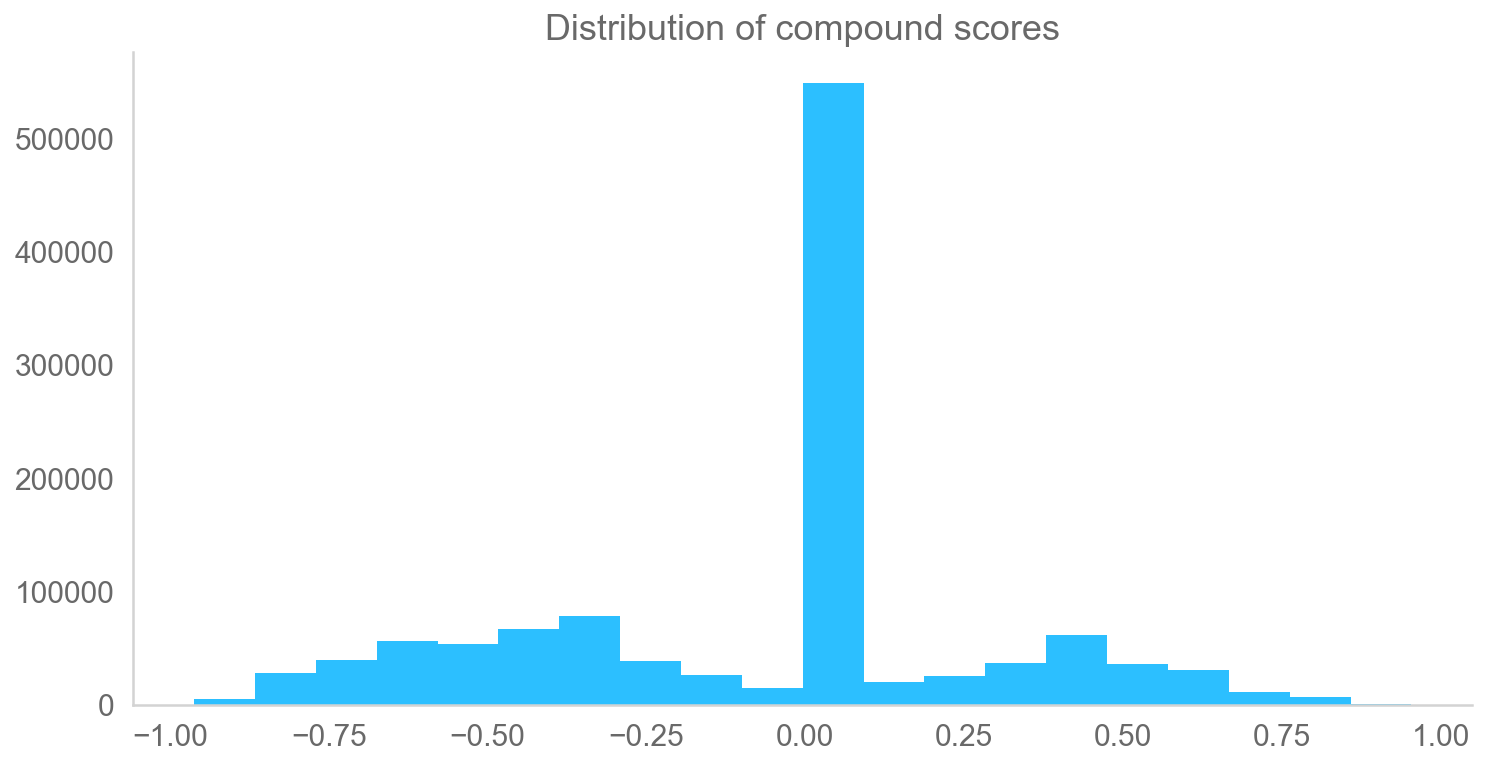

In [23]:
df["compound"].hist(figsize=(12, 6), bins=20, color="#2CBFFF", ec="none", grid=None)
plt.title("Distribution of compound scores");

In [24]:
df["compound"].value_counts().head()

 0.0000    531731
 0.4019     21114
-0.2960     20753
-0.3400     17528
-0.4019     17411
Name: compound, dtype: int64

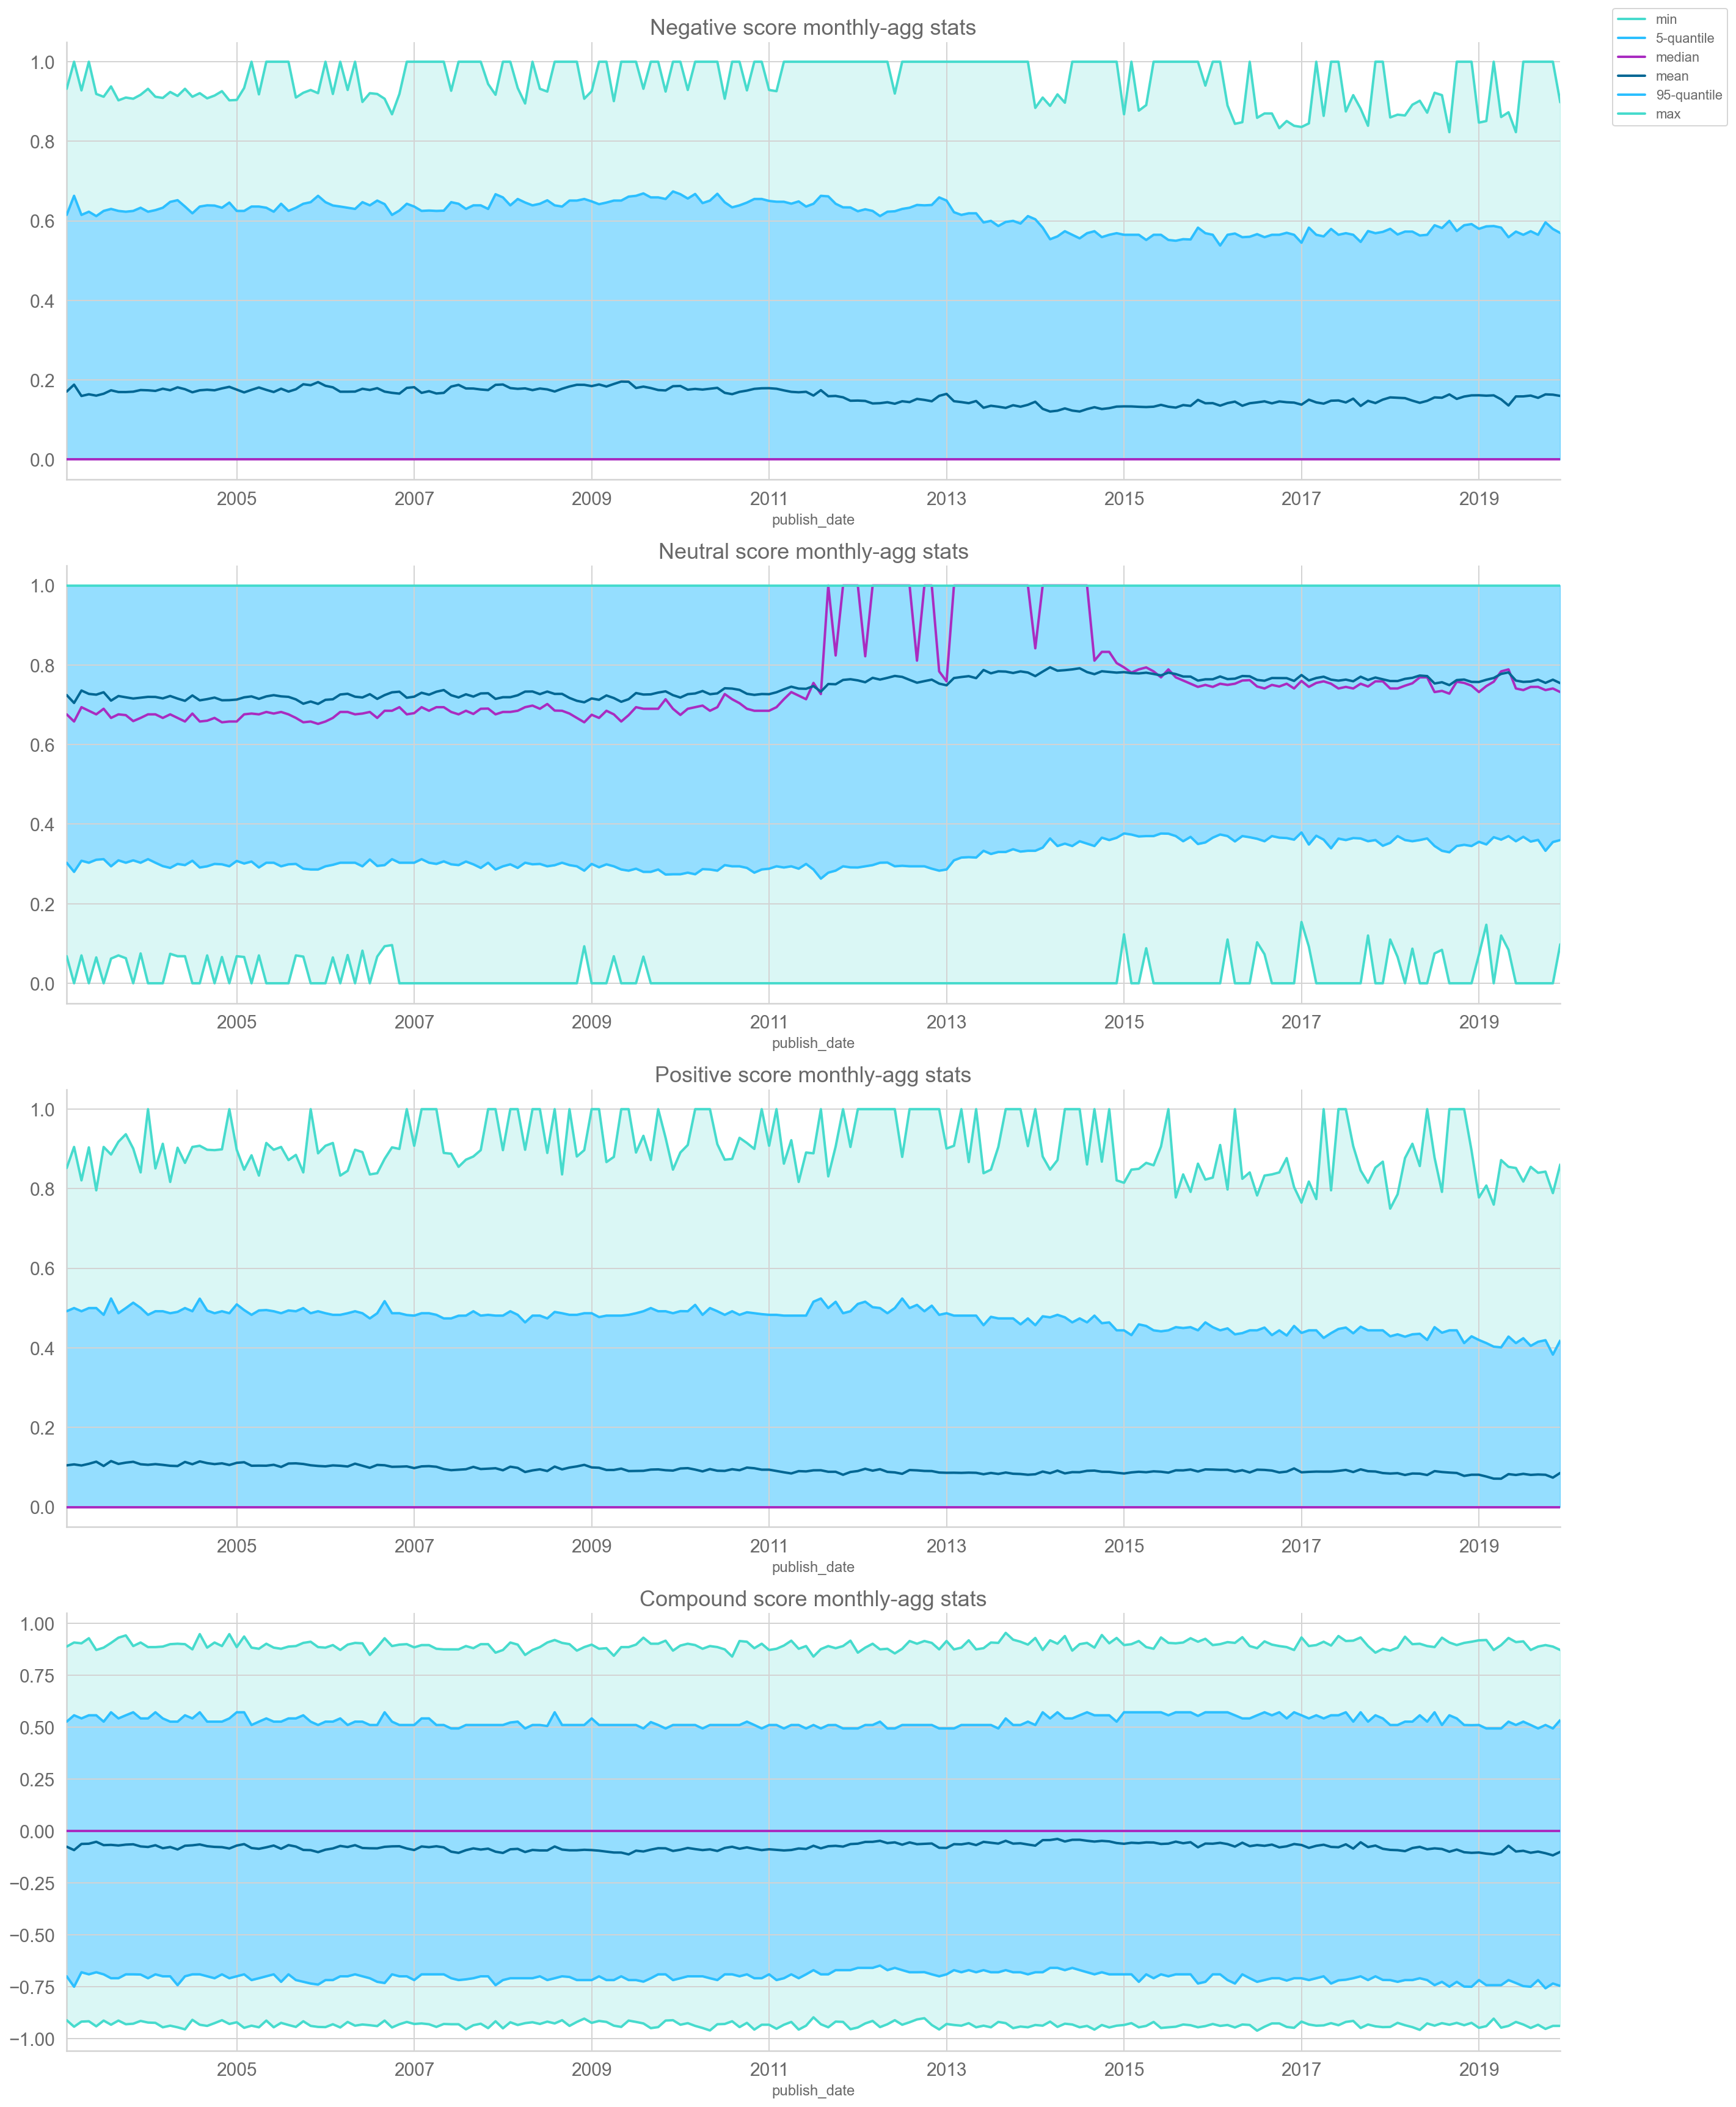

In [25]:
fig, axes = plt.subplots(4, 1, figsize=(18, 24))
for col, ax in zip(['Negative', 'Neutral', 'Positive', 'Compound'], axes):
    score_stats = (df.set_index("publish_date")
                     .resample("M")[col.lower()]
                     .agg(["min", lambda s: np.percentile(s, 5), "median", "mean", lambda s: np.percentile(s, 95), "max"])
                     .rename(columns={"<lambda_0>": "5-quantile", "<lambda_1>": "95-quantile"})
                  )
    score_stats.plot(color=["#47DBCD", "#2CBFFF", "#A92CC0", "#016794", "#2CBFFF", "#47DBCD"],
                     lw=2,
                     zorder=10,
                     ax=ax,
                     legend=None)

    ax.fill_between(score_stats.index,
                    score_stats["5-quantile"],
                    score_stats["95-quantile"],
                    color='#2CBFFF', alpha=.5)
    ax.fill_between(score_stats.index,
                    score_stats["max"],
                    score_stats["95-quantile"],
                    color="#47DBCD", alpha=.2)
    ax.fill_between(score_stats.index,
                    score_stats["min"],
                    score_stats["5-quantile"],
                    color="#47DBCD", alpha=.2)
    ax.set_title(f"{col} score monthly-agg stats")

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1))
fig.tight_layout()

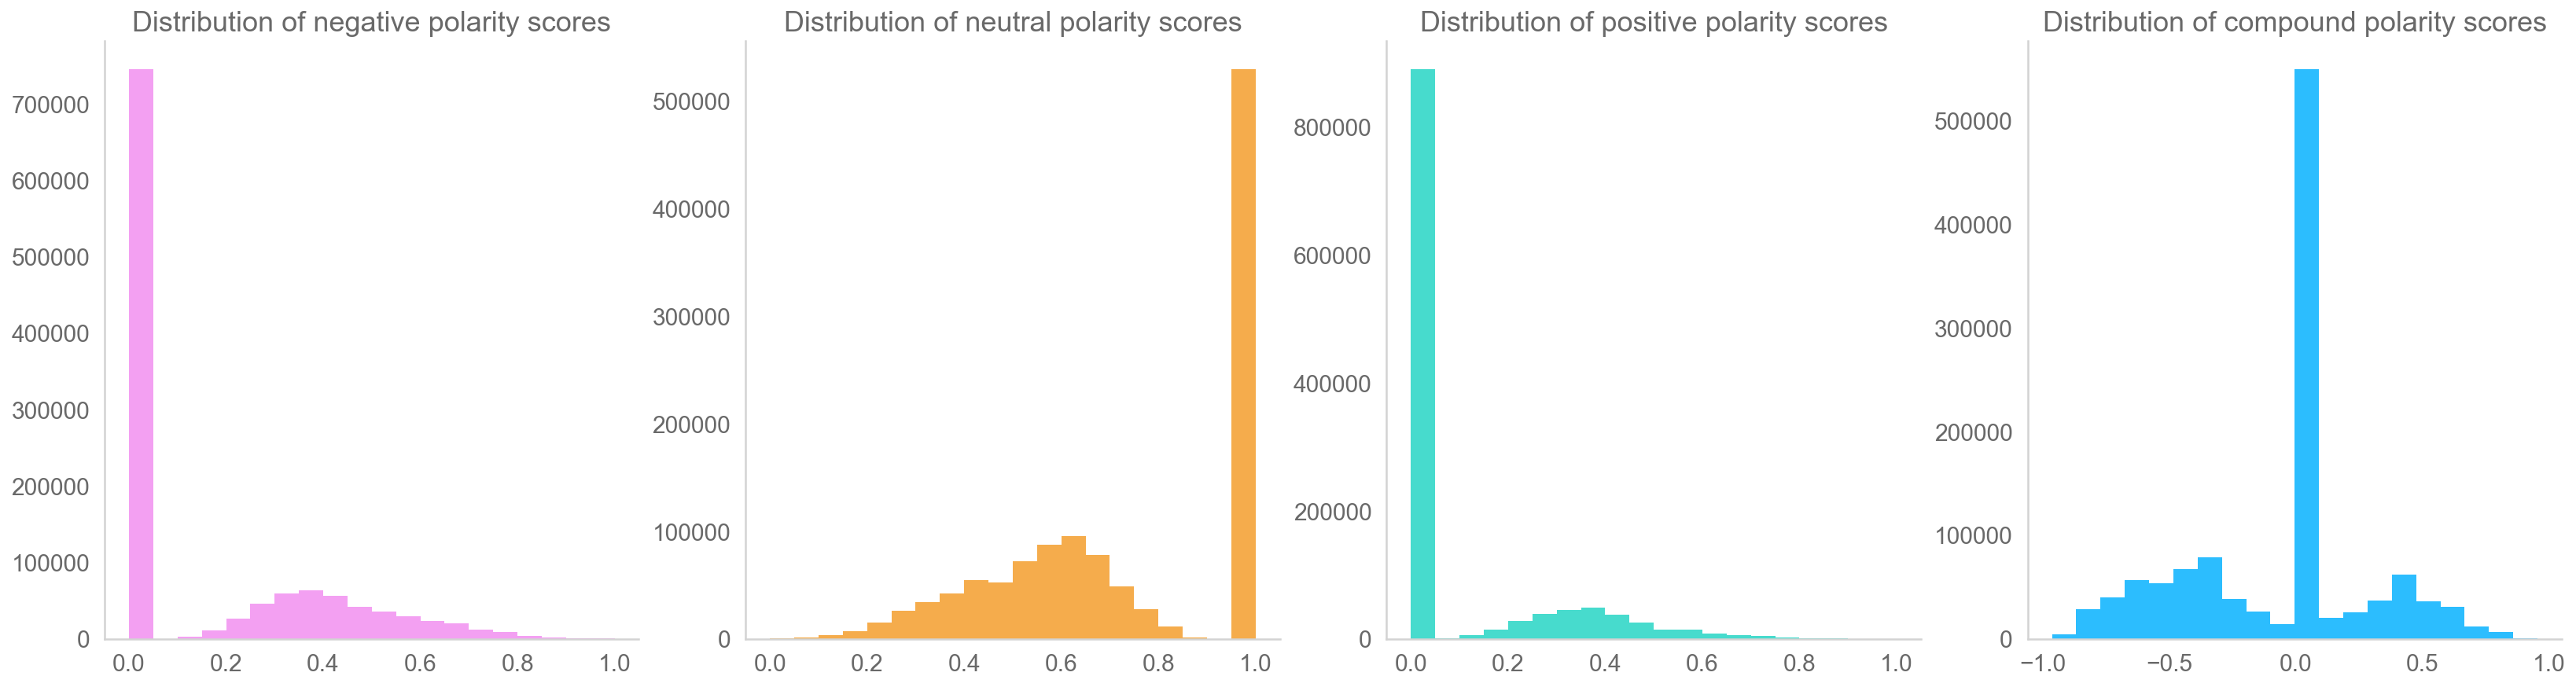

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(28, 7))
colors = ["#F3A0F2", "#F5AC4C", "#47DBCD", "#2CBDFE"]
for col, ax, color in zip(['negative', 'neutral', 'positive', 'compound'], axes, colors):
    ax.hist(df[col], bins=20, color=color, ec="none")
    ax.grid(None)
    ax.set_title(f"Distribution of {col} polarity scores")

In [27]:
reg = LinearRegression().fit(df[['negative', 'neutral', 'positive']], df['compound'])
print(f"R^2 = {reg.score(df[['negative', 'neutral', 'positive']], df['compound'])}")
print(f"Intercept = {reg.intercept_}")
print(f"coefficients = {reg.coef_.tolist()}")

R^2 = 0.9347175372618829
Intercept = 0.000523020995906523
coefficients = [-1.0818289176569922, 0.0014456214536750565, 1.0277146654131244]


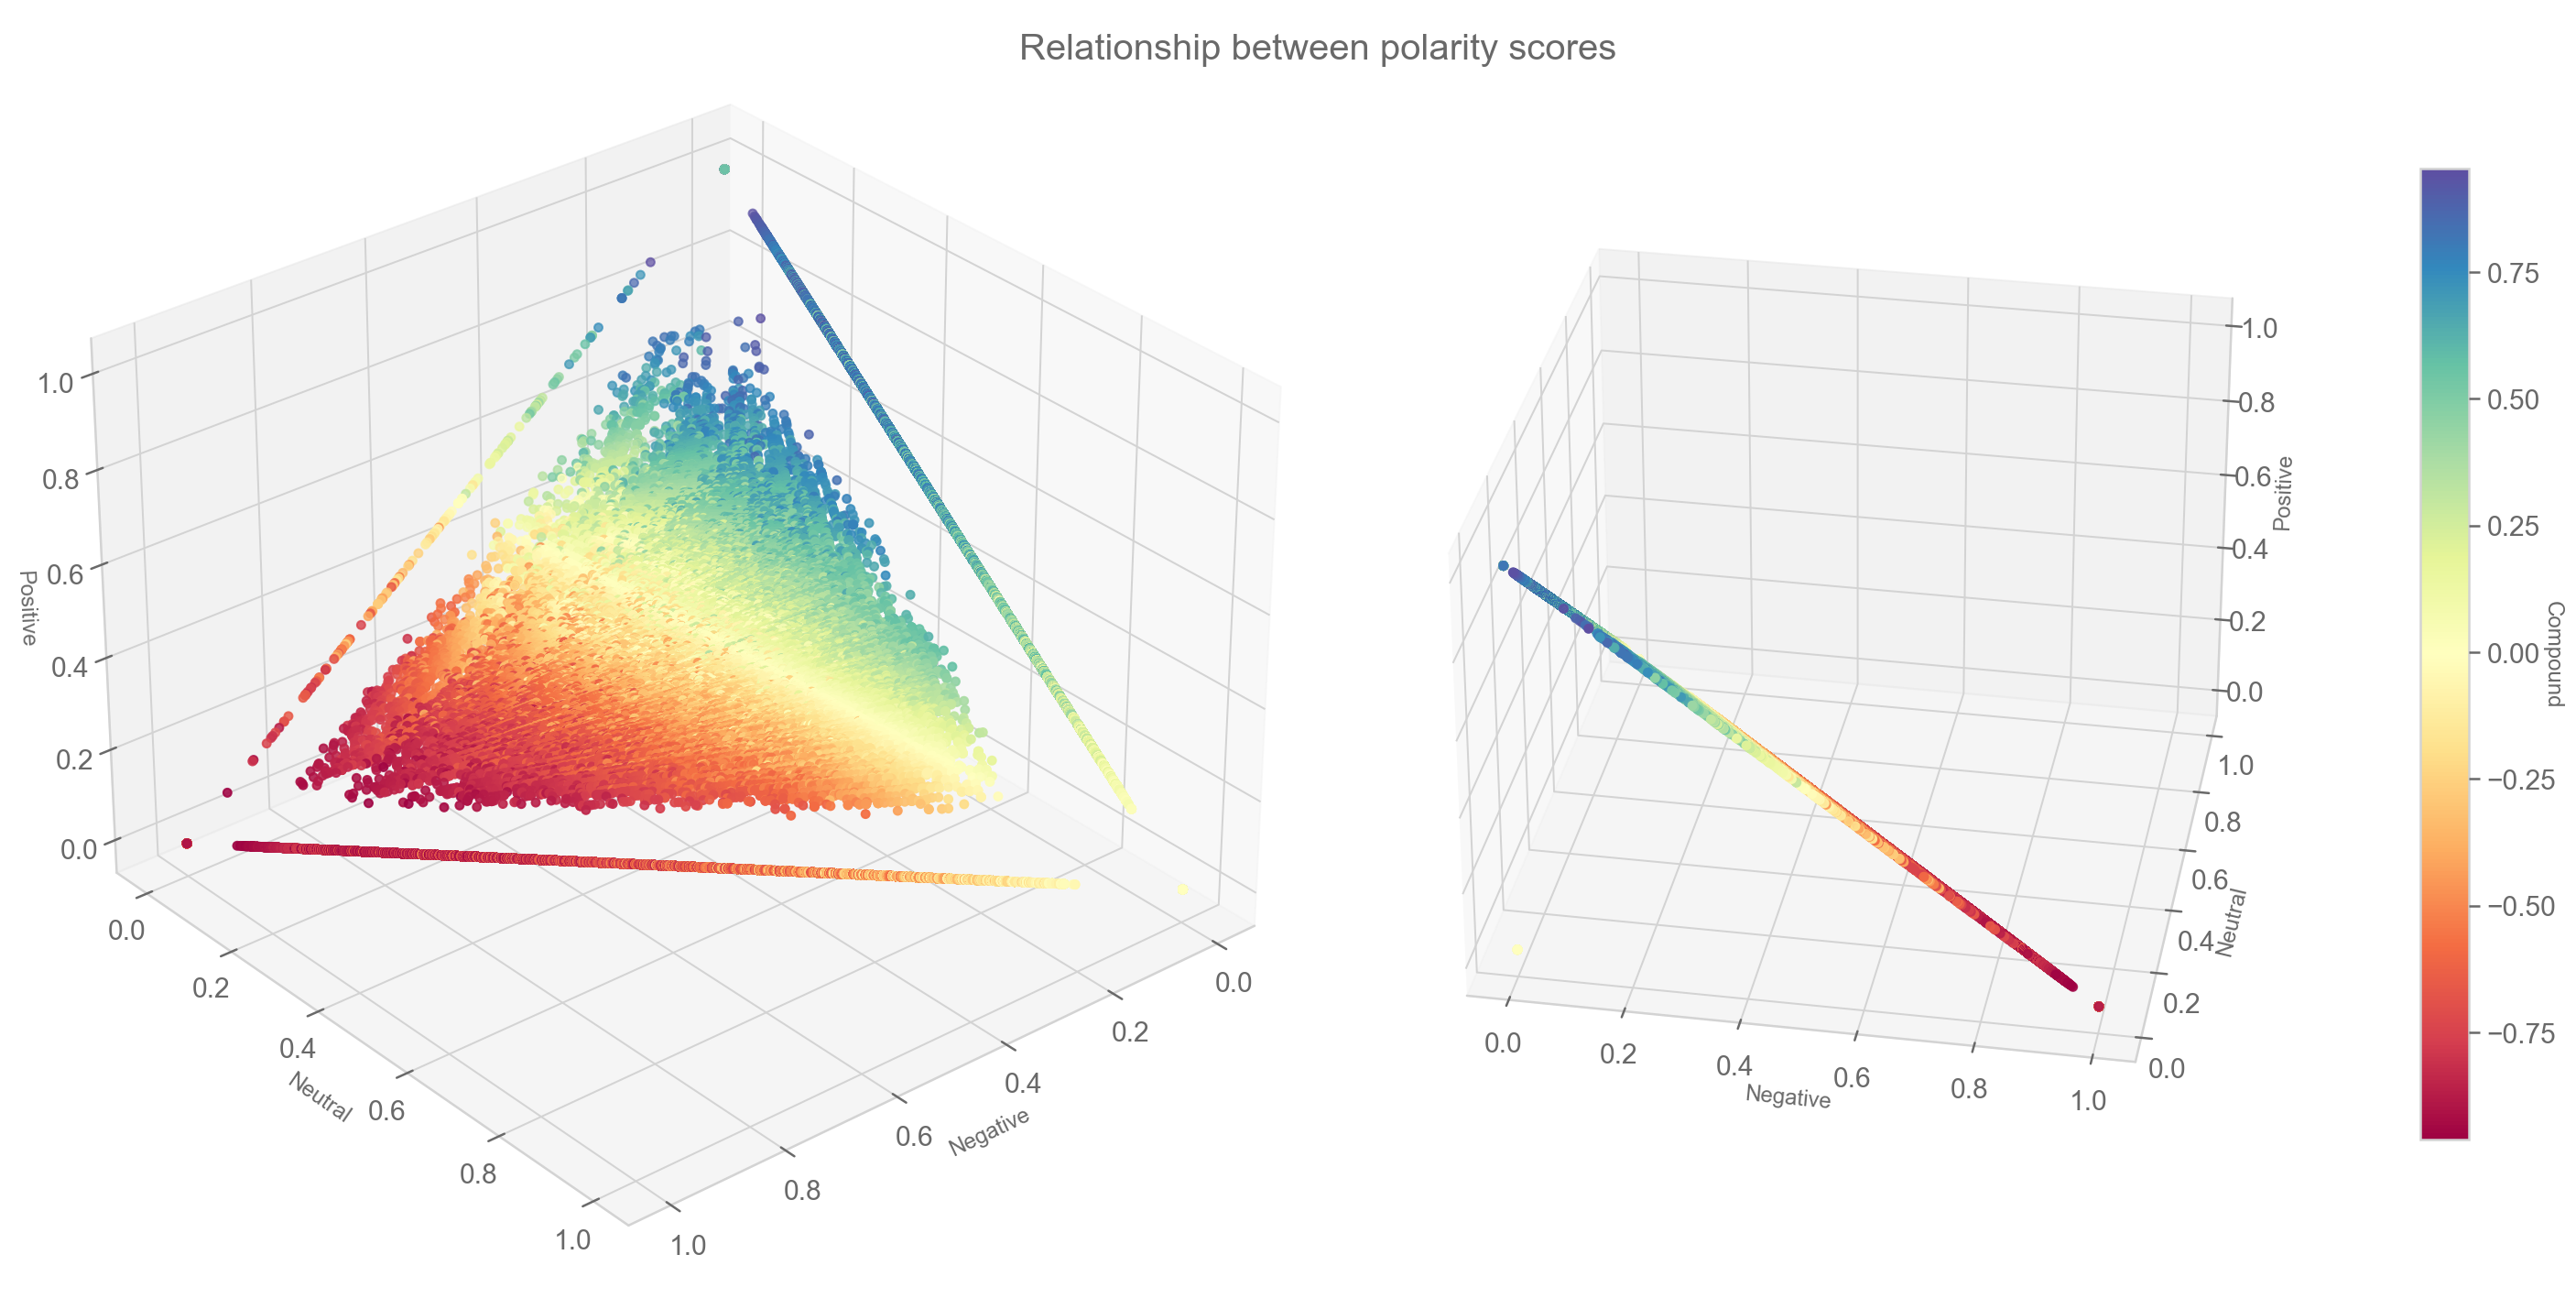

In [28]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

p = ax.scatter(df["negative"], df["neutral"], df["positive"], c=df["compound"],
               cmap=sns.color_palette("Spectral", as_cmap=True), s=20)
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
ax.set_zlabel('Positive')
ax.view_init(azim=50)
cbar = fig.colorbar(p, shrink=0.75)
cbar.ax.set_ylabel('Compound', rotation=270)
fig.suptitle("Relationship between polarity scores", fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=1)


ax2.scatter(df["negative"], df["neutral"], df["positive"], c=df["compound"],
            cmap=sns.color_palette("Spectral", as_cmap=True), s=20)
ax2.set_xlabel('Negative')
ax2.set_ylabel('Neutral')
ax2.set_zlabel('Positive')
ax2.view_init(azim=280);

## Topic modelling

In [29]:
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
df["headlines_reduced"] = (df["headline_without_stops"].str.split()
                           .apply(lambda s: list(map(lemmatizer.lemmatize, s)))
                           .apply(lambda s: list(map(stemmer.stem, s)))
                           .apply(lambda s: ' '.join(s)))

In [30]:
df

publish_date                                      headline_text  \
0         2003-02-19     a g calls for infrastructure protection summit   
1         2003-02-19  aba decides against community broadcasting lic...   
2         2003-02-19     act fire witnesses must be aware of defamation   
3         2003-02-19           air nz staff in aust strike for pay rise   
4         2003-02-19      air nz strike to affect australian travellers   
...              ...                                                ...   
1186013   2019-12-31  vision of flames approaching corryong in victoria   
1186014   2019-12-31  wa police and government backflip on drug amne...   
1186015   2019-12-31  we have fears for their safety: victorian premier   
1186016   2019-12-31                              when do the 20s start   
1186017   2019-12-31  yarraville shooting woman dead man critically ...   

                                    headline_without_stops  negative  neutral  \
0                 g calls infrastructure protection summit     0.000    1.000   
1               aba decides community broadcasting licence     0.000    1.000   
2                 act fire witnesses must aware defamation     0.324    0.676   
3                        air nz staff aust strike pay rise     0.367    0.633   
4               air nz strike affect australian travellers     0.231    0.769   
...                                                    ...       ...      ...   
1186013        vision flames approaching corryong victoria     0.000    0.667   
1186014    wa police government backflip drug amnesty bins     0.000    1.000   
1186015                    fears safety: victorian premier     0.368    0.263   
1186016                                          20s start     0.000    1.000   
1186017  yarraville shooting woman dead man critically ...     0.583    0.417   

         positive  compound                            headlines_reduced  
0           0.000    0.0000          g call infrastructur protect summit  
1           0.000    0.0000         aba decid communiti broadcast licenc  
2           0.000   -0.3400                 act fire wit must awar defam  
3           0.000   -0.2263            air nz staff aust strike pay rise  
4           0.000   -0.1280       air nz strike affect australian travel  
...           ...       ...                                          ...  
1186013     0.333    0.2500      vision flame approach corryong victoria  
1186014     0.000    0.0000    wa polic govern backflip drug amnesti bin  
1186015     0.368    0.0000               fear safety: victorian premier  
1186016     0.000    0.0000                                     20 start  
1186017     0.000   -0.7906  yarravill shoot woman dead man critic injur  

[1186018 rows x 8 columns]

In [31]:
count_vectorizer = CountVectorizer()
count_data = count_vectorizer.fit_transform(df["headlines_reduced"])
count_data

<1186018x76289 sparse matrix of type '<class 'numpy.int64'>'
	with 6327329 stored elements in Compressed Sparse Row format>

In [32]:
# number_of_topics = 5  # 10 seemed too many, 5 seems better
# lda = LDA(n_components=number_of_topics, n_jobs=-1, max_iter=5, verbose=10, random_state=1)
# lda.fit(count_data)
# with open("lda_model_v1.pickle", "wb") as f:
#     pickle.dump(lda, f)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.3min remaining:  3.9min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:  1.4min remaining:  1.9min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:  1.4min remaining:   58.4s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:  1.4min remaining:   27.6s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


iteration: 1 of max_iter: 5


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.3min remaining:  3.9min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:  1.4min remaining:  1.9min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:  1.4min remaining:   58.8s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:  1.4min remaining:   27.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.4min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


iteration: 2 of max_iter: 5


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.2min remaining:  3.6min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:  1.2min remaining:  1.7min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:  1.2min remaining:   53.5s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:  1.3min remaining:   25.1s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.3min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


iteration: 3 of max_iter: 5


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:  1.1min remaining:  3.2min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:  1.1min remaining:  1.5min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:  1.1min remaining:   48.0s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:  1.1min remaining:   22.5s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.2min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


iteration: 4 of max_iter: 5


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   59.1s remaining:  3.0min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:  1.0min remaining:  1.4min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:  1.0min remaining:   43.7s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:  1.0min remaining:   20.4s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:  1.1min finished
[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.


iteration: 5 of max_iter: 5


[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   47.9s remaining:  2.4min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:   49.0s remaining:  1.1min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   49.9s remaining:   35.6s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:   50.6s remaining:   16.9s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   51.2s finished


In [33]:
if "lda" not in globals():
    print("lda model not defined, reading from lda_model_v1.pickle")
    with open("lda_model_v1.pickle", "rb") as f:
        lda = pickle.load(f)

In [34]:
words = count_vectorizer.get_feature_names()
print("Topics found via LDA:\n")
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}")
    print(" ".join([words[i] for i in topic.argsort()[:-20 - 1:-1]]))

Topics found via LDA:

Topic 0
say council govt new warn elect job rise australian farmer rate cut call labor sa law pay green urg opposit
Topic 1
interview fire abc final countri new one death busi world australia cup port hour take news victim wa farm weather
Topic 2
polic plan crash miss call new back driver kill car attack road report train water search probe servic council help
Topic 3
day win south pm health open urg west australia test protest student north fund end market strike record continu rain
Topic 4
man charg court woman murder face jail accus kill year death drug arrest trial child case polic sydney assault mine


In [35]:
# lda_vis_prep = sklearn_lda.prepare(lda, count_data, count_vectorizer)
# with open("lda_vis_prep.pickle", 'wb') as f:
#     pickle.dump(lda_vis_prep, f)

[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   3 out of  12 | elapsed:   47.7s remaining:  2.4min
[Parallel(n_jobs=12)]: Done   5 out of  12 | elapsed:   49.6s remaining:  1.2min
[Parallel(n_jobs=12)]: Done   7 out of  12 | elapsed:   50.0s remaining:   35.7s
[Parallel(n_jobs=12)]: Done   9 out of  12 | elapsed:   50.5s remaining:   16.8s
[Parallel(n_jobs=12)]: Done  12 out of  12 | elapsed:   51.3s finished


In [36]:
if "lda_vis_prep" not in globals():
    print("lda_vis_prep not defined, reading from lda_vis_prep.pickle")
    with open("lda_vis_prep.pickle", "rb") as f:
        lda_vis_prep = pickle.load(f)

In [37]:
pyLDAvis.display(lda_vis_prep)

In [38]:
pyLDAvis.save_html(lda_vis_prep, './lda_vis_prep.html')